In [6]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import os
from PIL import Image

# source: https://github.com/cjmcgill/characterizing_uncertainty_scripts/blob/main/figure_scripts/figure_8.py
from multiprocessing import Pool, cpu_count

def compute_interval(args):
    upper, unce, pred, true = args
    ctr = 0
    for u, p, t in zip(unce, pred, true):
        s = np.sqrt(u)
        i = stats.norm.interval(confidence=upper, loc=p, scale=s)
        if t >= i[0] and t <= i[1]:
            ctr += 1
    return ctr

def compute_auce(pred, unce, true, q=10, num_processes=None):
    if num_processes is None:
        num_processes = cpu_count()  # Use all available CPUs if not specified

    calibration_x = [0]
    calibration_y = [0]
    calibration_y_oracle = [0]
    auce = 0

    # Prepare arguments for each process
    args = [( (i+1)*1/q, unce, pred, true) for i in range(q)]

    with Pool(processes=num_processes) as pool:
        results = pool.map(compute_interval, args)

    for i in range(q):
        upper = (i + 1) * 1 / q
        ctr = results[i]
        calibration_x.append(upper)
        calibration_y.append(ctr / len(unce))
        calibration_y_oracle.append(upper)
        auce += abs(ctr / len(unce) - upper) * 1 / q

    return auce, calibration_x, calibration_y, calibration_y_oracle

def create_subplot_auce(system, true, pred, unce, xlabel=False, ylabel=False):
    target_name_dict = {"1syh score":"1SYH score (-)", "4lde score":"4LDE score (-)", "6y2f score":"6Y2F score (-)",
                    "singlet-triplet value":"Singlet-triplet gap (eV)", "oscillator strength":"Oscillator strength (-)", 
                    "abs_diff_vee":"Abs. diff.of VEE (eV)",
                    "activation_energy":"Activation energy (kcal/mol)", "reaction_energy":"Reaction energy (kcal/mol)",
                    "1syh_score":"1SYH score (-)", "4lde_score":"4LDE score (-)", "6y2f_score":"6Y2F score (-)",
                    "singlet-triplet_value":"Singlet-triplet gap (eV)", "oscillator_strength":"Oscillator strength (-)", 
                    'similarity_Aripiprazole':'Similarity to aripiprazole (-)',
                    'similarity_Albuterol': 'Similarity to albuterol (-)', 'similarity_Mestranol':'Similarity to mestranol (-)',
                    'similarity_Tadalafil': 'Similarity to tadalafil (-)', 'similarity_Sildenafil':'Similarity to sildenafil (-)',
                    'similarity_Camphor': 'Similarity to camphor (-)', 'similarity_Menthol': 'Similarity to menthol (-)',
                    'similarity_Fexofenadine': 'Similarity to fexofenadine (-)', 'similarity_Ranolazine': 'Smilarity to ranolazine (-)',
                    'logP': 'logP (-)', "tpsa": "TPSA ($\AA^2$)"}
    auce, calibration_x, calibration_y, calibration_y_oracle = compute_auce(pred, unce, true, q=20)
    plt.plot(calibration_x,calibration_y,color='darkorange')
    plt.plot(calibration_x,calibration_y_oracle,color='gray')
    plt.fill_between(calibration_x,calibration_y,calibration_y_oracle, color='lightgray')
    plt.title(target_name_dict[system],fontsize=17)
    plt.text(0.15,0.9,"AUCE "+str(np.round(auce,4)), fontsize=18)
    plt.xticks(fontsize=13)
    plt.yticks(fontsize=13)
    if xlabel:
        plt.xlabel("Confidence level", fontsize=16)
    if ylabel:
        plt.ylabel("Proportion of data within\nthe confidence interval", fontsize=16)
    print(system, auce)


## Plot all auce plots

singlet-triplet value 0.030956801584354498
oscillator strength 0.07108367372199531
abs_diff_vee 0.03057989850228989
1syh score 0.043814839133289554
4lde score 0.03307616546290216
6y2f score 0.014179251477347344
activation_energy 0.029193654446818998
reaction_energy 0.055609896432681244
similarity_Aripiprazole 0.07353
similarity_Albuterol 0.027054999999999996
similarity_Mestranol 0.02577
similarity_Tadalafil 0.09423
similarity_Sildenafil 0.06853
similarity_Camphor 0.076095
similarity_Menthol 0.076135
similarity_Fexofenadine 0.06087499999999999
similarity_Ranolazine 0.08772
logP 0.028215
tpsa 0.013434999999999996


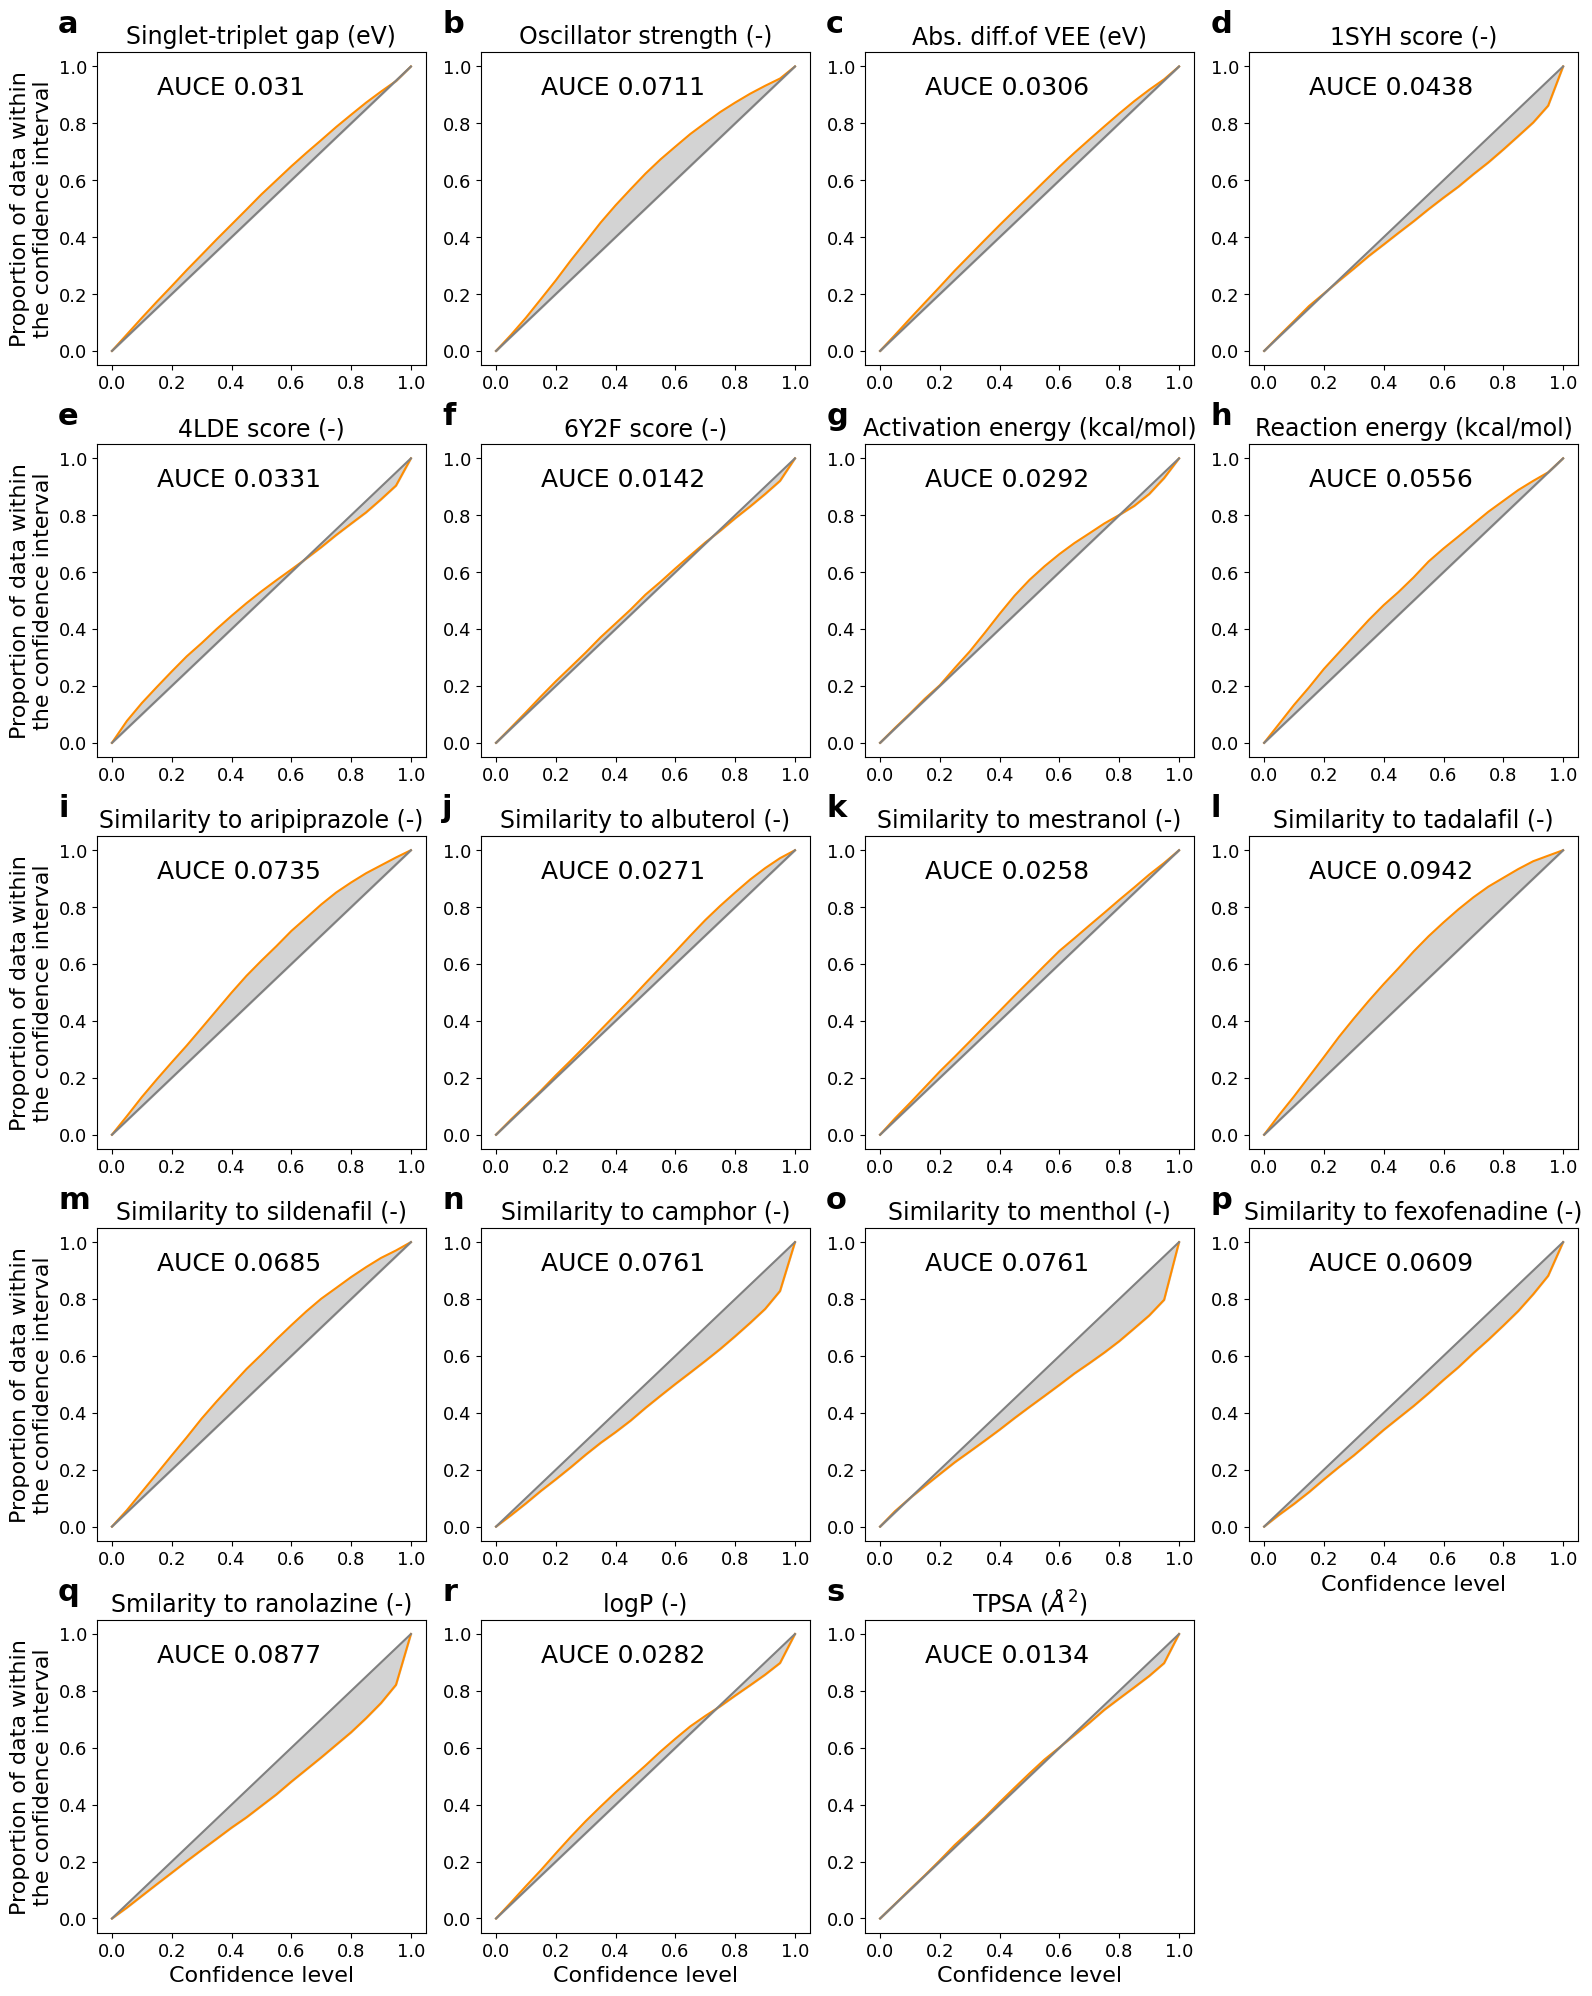

In [7]:
dataset_target = [("organic_emitter", "singlet-triplet value"), ("organic_emitter", "oscillator strength"), ("organic_emitter", "abs_diff_vee"),
                  ("docking", "1syh score"), ("docking", "4lde score"), ("docking", "6y2f score"),
                  ("reactivity", "activation_energy"), ("reactivity", "reaction_energy")]
model_dict = {"docking":"chemprop_unc/save_models/docking_evidential/fold_0",
              "organic_emitter":"chemprop_unc/save_models/organic_emitter_ensemble_mve/fold_0",
              "reactivity":"chemprop_unc/save_models/reactivity_evidential/fold_0"}
uncertainty_method_dict = {"docking": "evidential_total_uncal_var",
                           "organic_emitter": "mve_uncal_var",
                           "reactivity": "evidential_total_uncal_var"}

target_model_columns = [('similarity_Aripiprazole', 'trial_30'),
       ('similarity_Albuterol', 'trial_30'), ('similarity_Mestranol', 'trial_30'),
       ('similarity_Tadalafil', 'trial_30'), ('similarity_Sildenafil', 'trial_30'), 
       ('similarity_Camphor', 'trial_24'), ('similarity_Menthol', 'trial_20'),
       ('similarity_Fexofenadine', 'trial_24'), ('similarity_Ranolazine', 'trial_19'),
       ('logP', 'trial_3'), ('tpsa', 'trial_24')]

mixed_info = dataset_target + target_model_columns
labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k','l', 'm','n','o', 'p','q','r','s']

fig, axs = plt.subplots(5, 4, figsize=(16, 20), dpi=100)

# for i, (dataset, target) in enumerate(dataset_target):
for i, ax in enumerate(axs.flat):
    if i == 19:
        ax.axis('off')
        break
    xlabel = False
    ylabel = False
    j = i + 1
    if i in [0,4,8,12,16]:
        ylabel=True
    if i in [15,16,17,18]:
        xlabel=True
    plt.subplot(5,4,int(j))

    if i < 8: # Tartarus
        dataset, target = mixed_info[i]
        model_path = model_dict[dataset]
        uncertainty_method = uncertainty_method_dict[dataset]
        unc_name = target + "_" + uncertainty_method
        true_df = pd.read_csv(os.path.join(model_path, "test_full.csv"))
        pred_df = pd.read_csv(os.path.join(model_path, "test_unc.csv"))
        true = true_df[target]
        pred = pred_df[target]
        unce = pred_df[unc_name]
    else:
        target, model = mixed_info[i]
        unc_name = target + "_" + "evidential_total_uncal_var"
        model_path = f"chemprop_unc/save_models/guacamol/{target}/{model}/fold_0"
        true_df = pd.read_csv("guacamol_benchmark/guacamol_dataset/guacamol_sample_test.csv")
        pred_df = pd.read_csv(os.path.join(model_path, "test_unc.csv"))
        true = true_df[target]
        pred = pred_df[target]
        unce = pred_df[unc_name]
    create_subplot_auce(target, true, pred, unce, xlabel=xlabel, ylabel=ylabel)
    plt.text(-0.18, 1.20, labels[i], color='black', fontsize=22, va='top', ha='left', weight="bold")

plt.tight_layout()
plt.savefig("figures/finals/auce_plots/overall_auce.svg", format="svg")

In [16]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
import os
from scipy.stats import norm
target_name_dict = {"singlet-triplet value":"singlet-triplet gap (eV)", "oscillator strength":"oscillator strength (-)", 
                    "abs_diff_vee":"abs. diff.of VEE (eV)",
                    "activation_energy":"activation energy (kcal/mol)", "reaction_energy":"reaction energy (kcal/mol)",
                    "singlet-triplet_value":"singlet-triplet gap (eV)", "oscillator_strength":"oscillator strength (-)", 
                    'similarity_Tadalafil': 'similarity to tadalafil (-)', 'similarity_Sildenafil':'similarity to sildenafil (-)',
                    'similarity_Camphor': 'similarity to camphor (-)', 'similarity_Menthol': 'similarity to menthol (-)',
                    'similarity_Fexofenadine': 'similarity to fexofenadine (-)', 'similarity_Ranolazine': 'smilarity to ranolazine (-)',
                    'logP': 'logP (-)', "tpsa": "TPSA ($\AA^2$)"}

def create_error_dist(list1, list2, xlabel=None, ylabel=None, save_path=None):
    correlation_matrix = np.corrcoef(list1, list2)
    correlation_coefficient = correlation_matrix[0, 1]
    
    color = "#4169E1"
    df = pd.DataFrame({"x": list1, "y": list2})
    fig = plt.subplots(dpi=300, figsize = (5, 5))
    ax_scatter = plt.subplot2grid((4, 4), (1, 0), rowspan=3, colspan=3)
    ax_histx = plt.subplot2grid((4, 4), (0, 0), colspan=3)
    ax_histy = plt.subplot2grid((4, 4), (1, 3), rowspan=3)

    # X軸數據的Gaussian fit
    mu_x, std_x = norm.fit(df["x"])
    x_range = np.linspace(df["x"].min(), df["x"].max(), 100)
    gauss_x = norm.pdf(x_range, mu_x, std_x)
    # Y軸數據的Gaussian fit
    mu_y, std_y = norm.fit(df["y"])
    y_range = np.linspace(df["y"].min(), df["y"].max(), 100)
    gauss_y = norm.pdf(y_range, mu_y, std_y)

    ax_scatter.scatter(df["x"], df["y"], c=color, marker='o', alpha=0.55 ,s=10, linewidths=0.25, edgecolors="black")
    ax_scatter.text(0.15, 0.85, f"Correlation\ncoefficient: {correlation_coefficient:.3f}", transform=ax_scatter.transAxes, fontsize=16)
    ax_scatter.set_xlabel(xlabel,fontsize=14)
    ax_scatter.set_ylabel(ylabel, fontsize=14)
    sns.histplot(df, x="x", bins=50, ax=ax_histx, color=color, stat='density', element='step', legend=False)
    ax_histx.plot(x_range, gauss_x, color='red', linestyle='-', linewidth=1.0)
    ax_histx.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax_histx.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    ax_histx.set_xlabel(None)

    sns.histplot(df, y="y", bins=50, ax=ax_histy, color=color,stat='density', element='step', legend=False)
    ax_histy.plot(gauss_y, y_range, color='red', linestyle='-', linewidth=1.0)
    ax_histy.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax_histy.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    ax_histy.set_ylabel(None)
    plt.tight_layout()
    if save_path:
        plt.savefig(save_path, format="png")
    
    plt.show()

images_fies = []

/tmp/ipykernel_52888/20081029.py:23: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax_scatter = plt.subplot2grid((4, 4), (1, 0), rowspan=3, colspan=3)


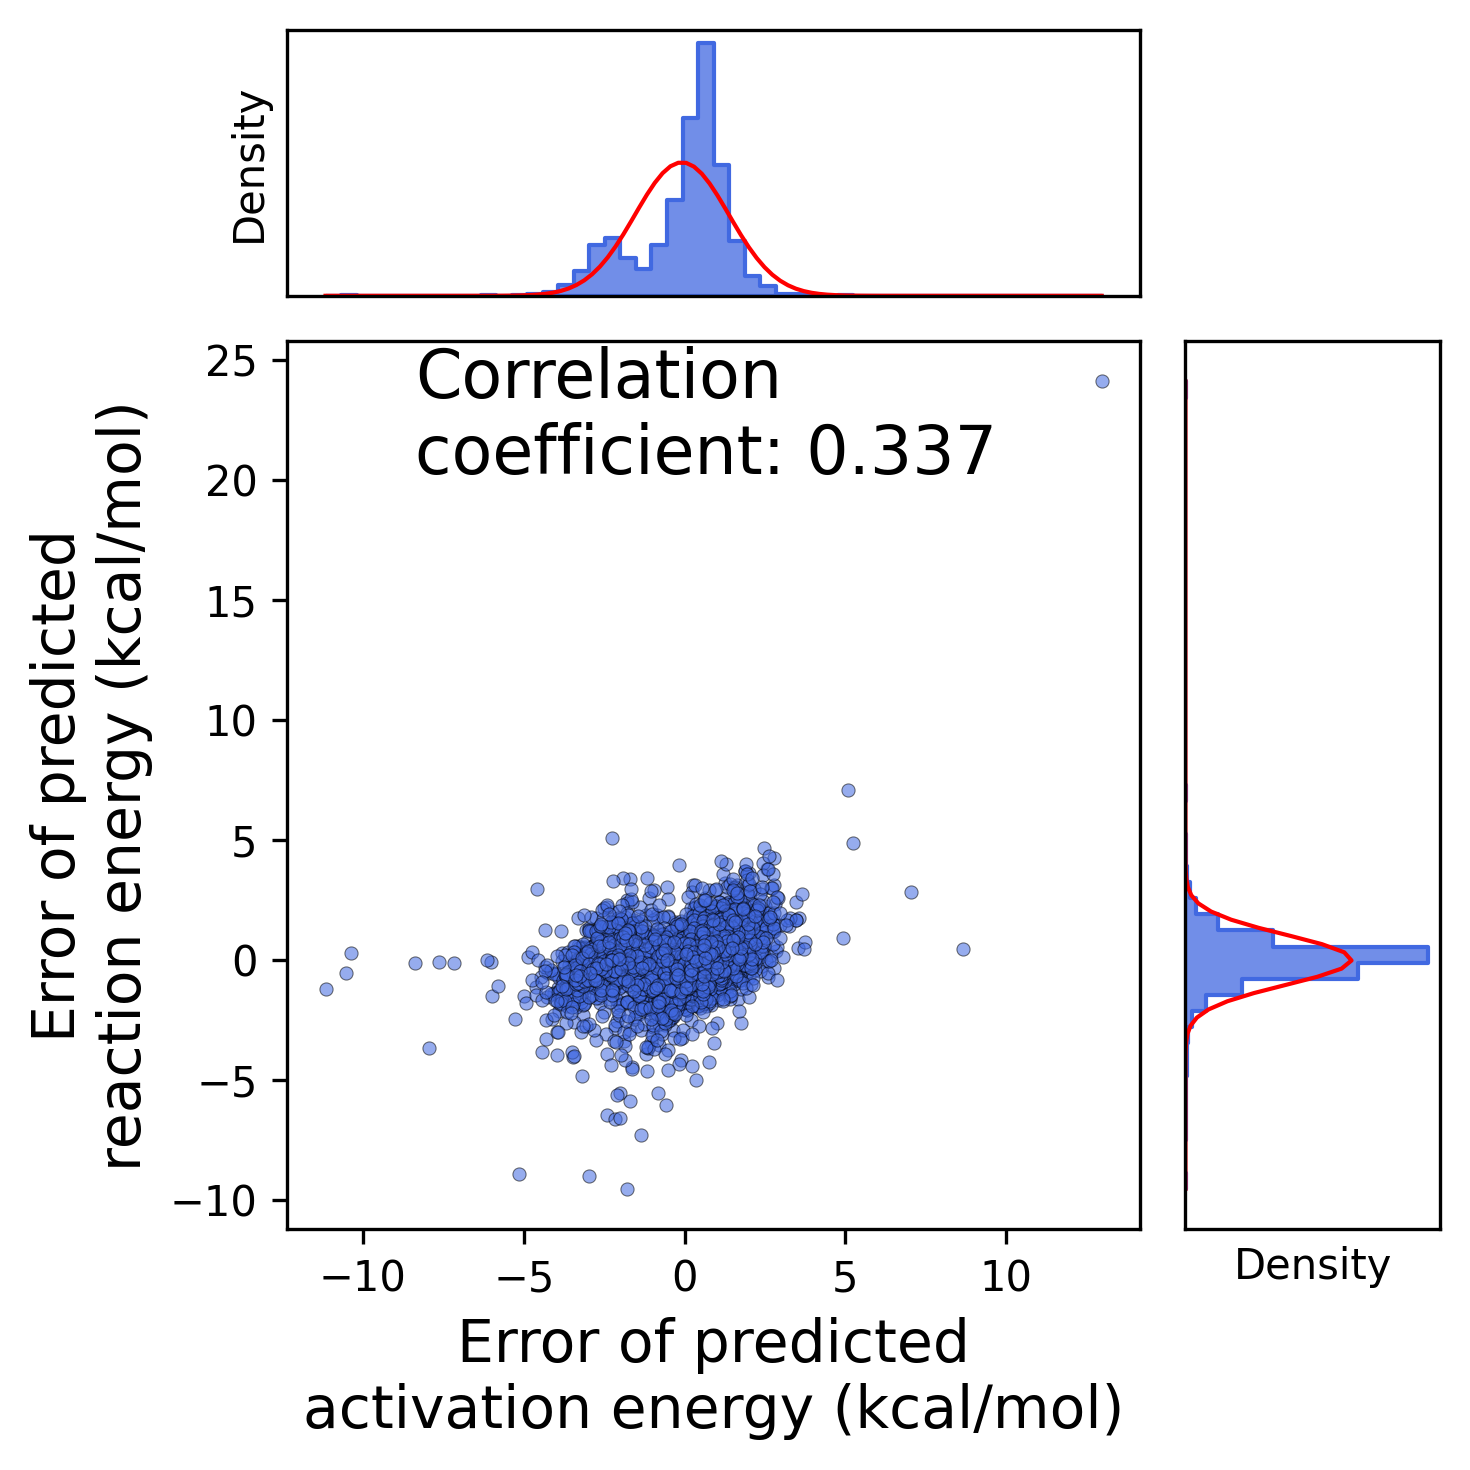

/tmp/ipykernel_52888/20081029.py:23: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax_scatter = plt.subplot2grid((4, 4), (1, 0), rowspan=3, colspan=3)


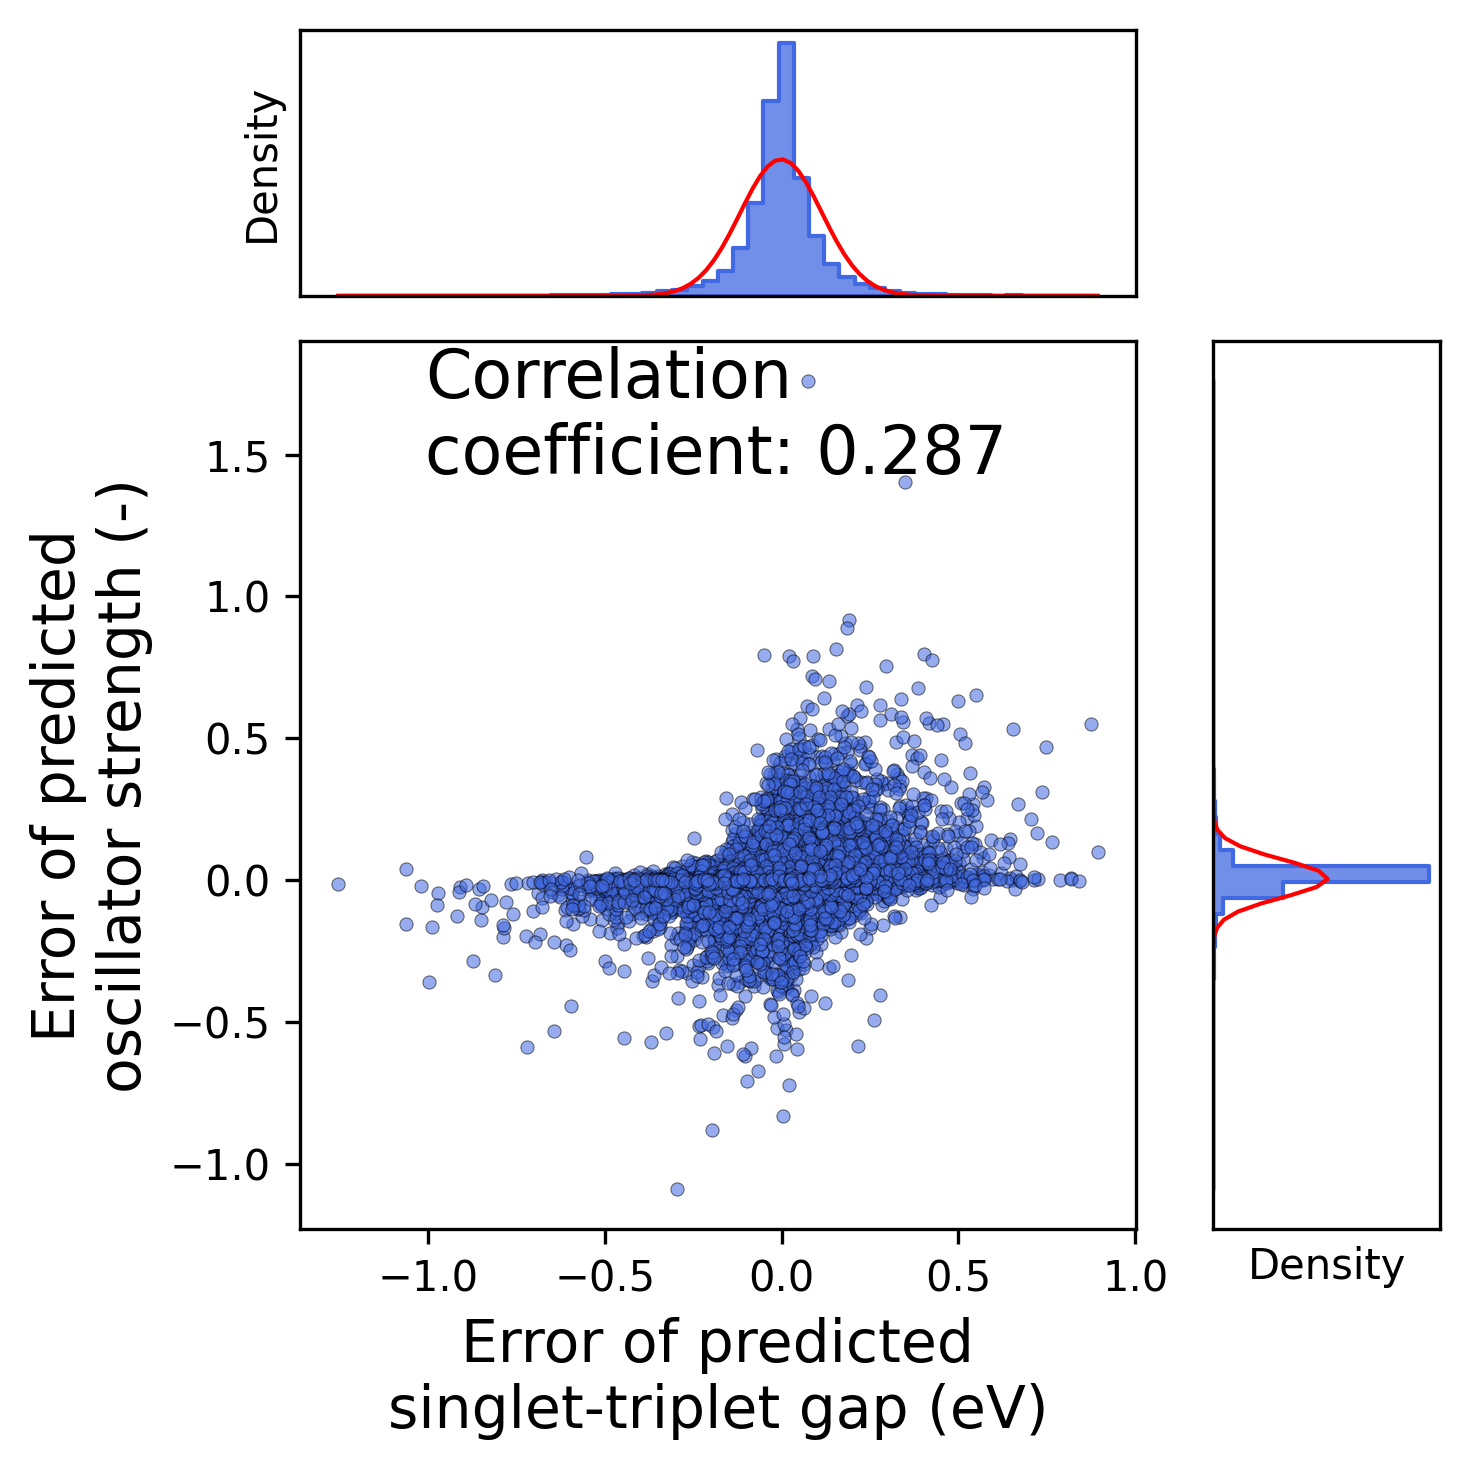

/tmp/ipykernel_52888/20081029.py:23: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax_scatter = plt.subplot2grid((4, 4), (1, 0), rowspan=3, colspan=3)


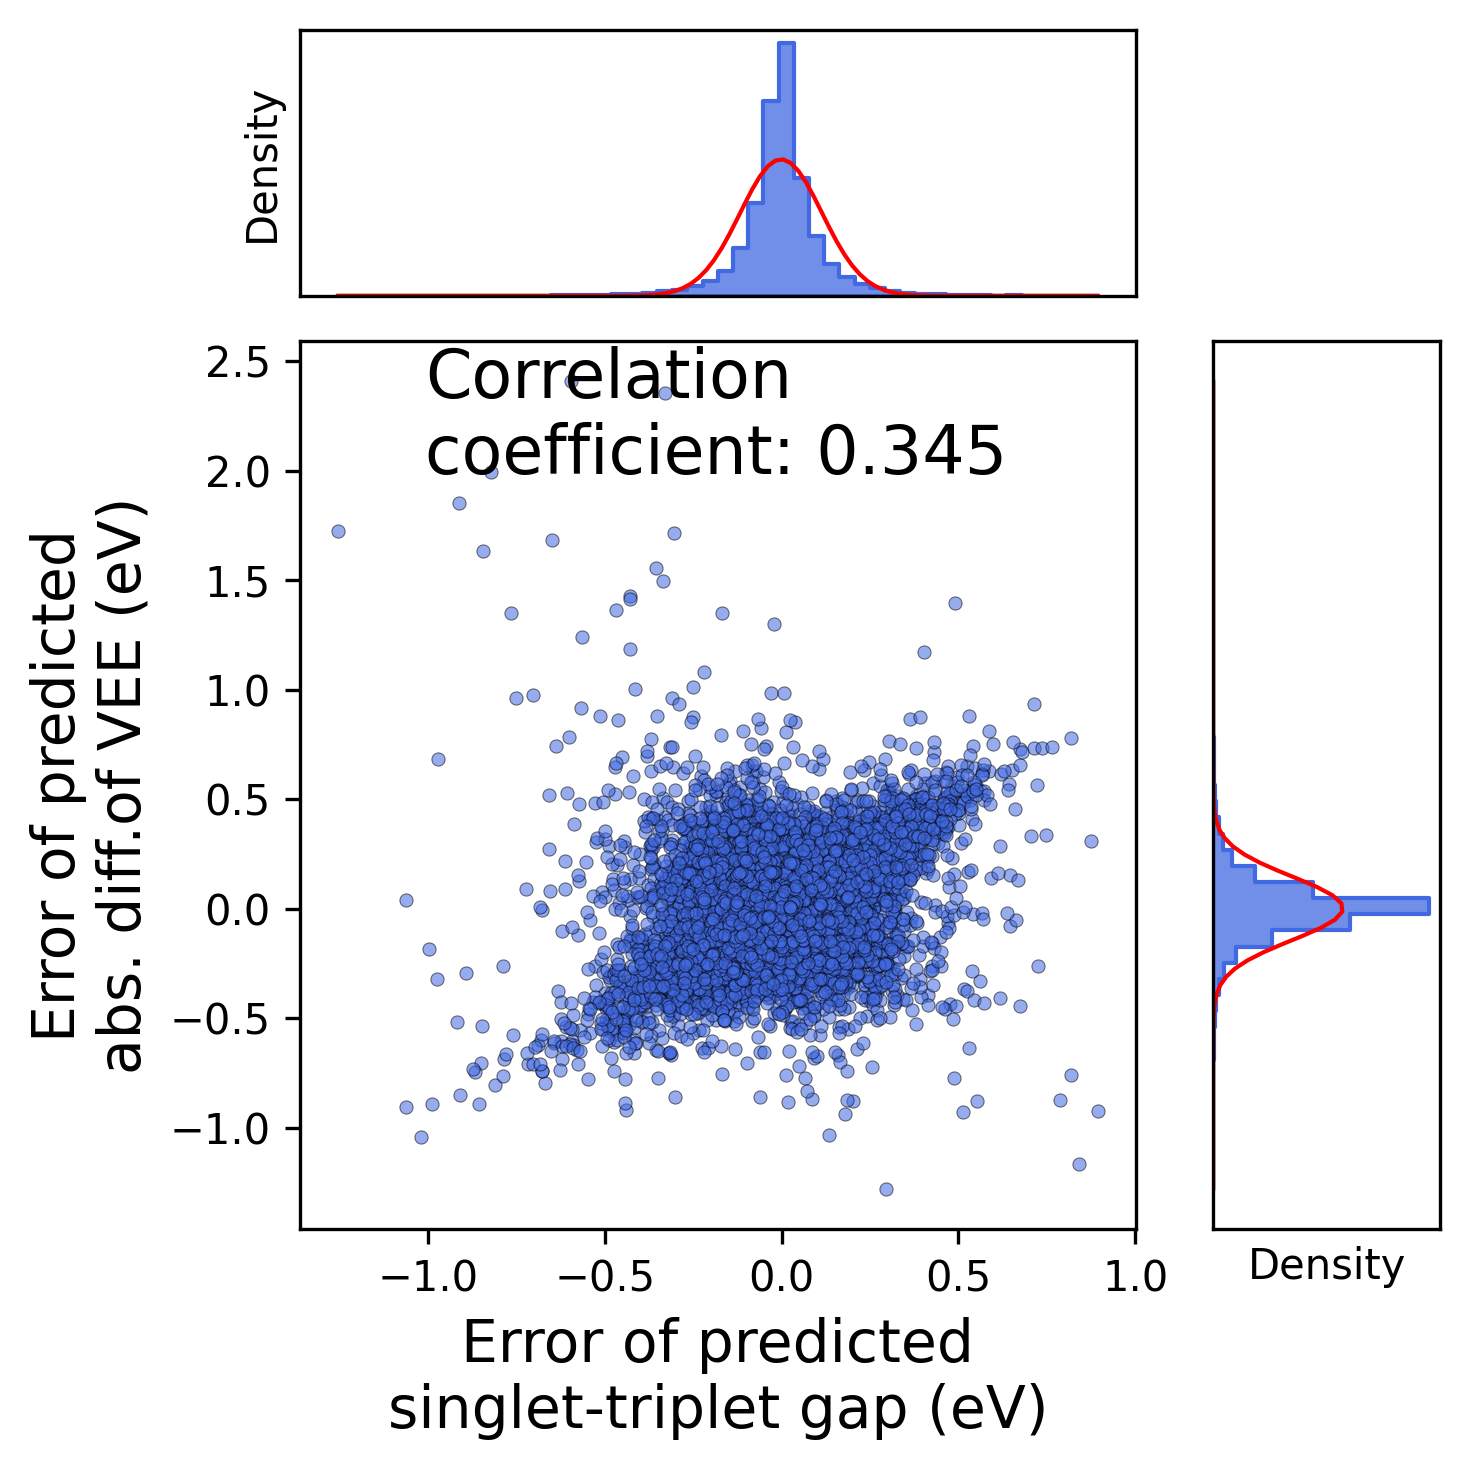

/tmp/ipykernel_52888/20081029.py:23: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax_scatter = plt.subplot2grid((4, 4), (1, 0), rowspan=3, colspan=3)


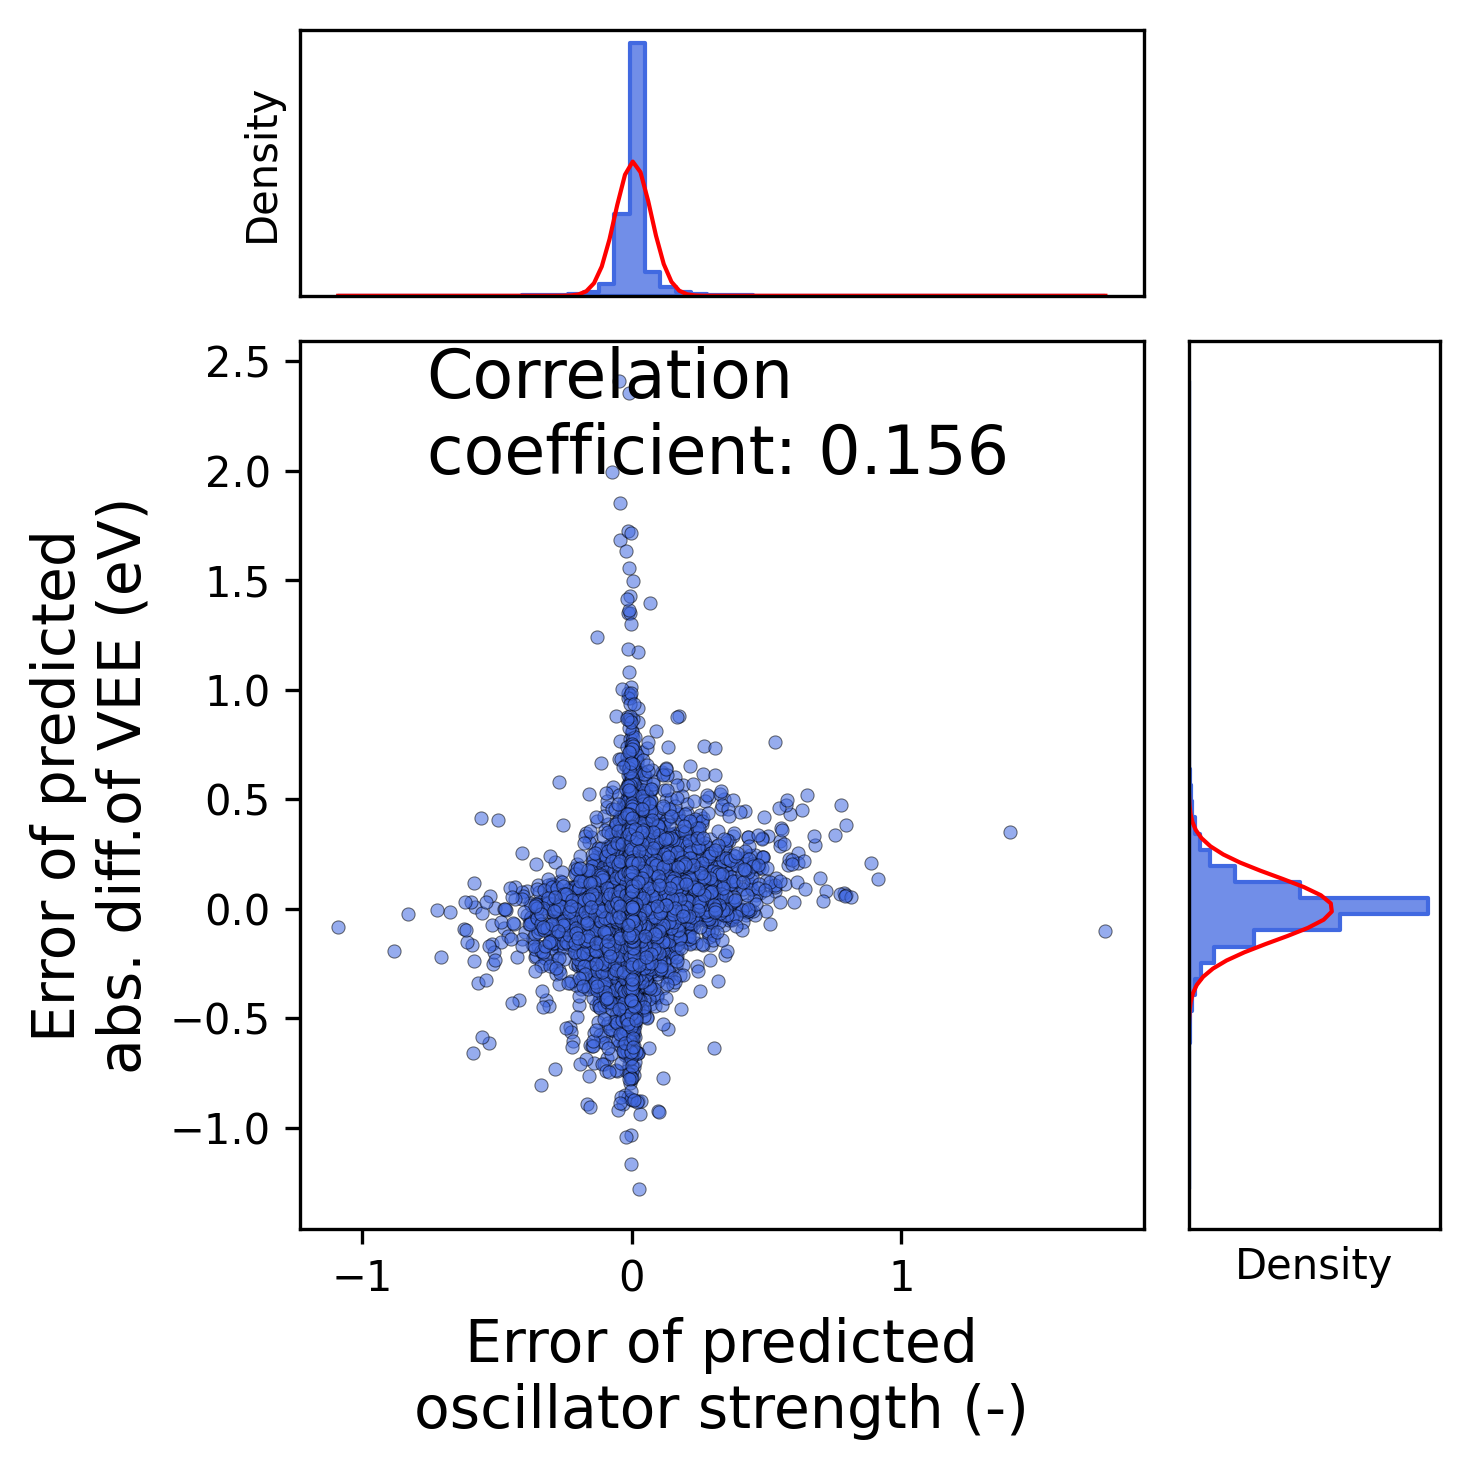

In [17]:
dataset_targets = [[("reactivity", "activation_energy"), ("reactivity", "reaction_energy")],
                  [("organic_emitter", "singlet-triplet value"), ("organic_emitter", "oscillator strength")],
                  [("organic_emitter", "singlet-triplet value"), ("organic_emitter", "abs_diff_vee")],
                  [("organic_emitter", "oscillator strength"), ("organic_emitter", "abs_diff_vee")]]
model_dict = {"docking":"chemprop_unc/save_models/docking_evidential/fold_0",
              "organic_emitter":"chemprop_unc/save_models/organic_emitter_ensemble_mve/fold_0",
              "reactivity":"chemprop_unc/save_models/reactivity_evidential/fold_0"}
uncertainty_method_dict = {"docking": "evidential_total_uncal_var",
                           "organic_emitter": "mve_uncal_var",
                           "reactivity": "evidential_total_uncal_var"}

for dataset_target in dataset_targets:
    dataset, target_0 = dataset_target[0]
    dataset, target_1 = dataset_target[1]
    model_path = model_dict[dataset]
    uncertainty_method = uncertainty_method_dict[dataset]
    true_df = pd.read_csv(os.path.join(model_path, "test_full.csv"))
    pred_df = pd.read_csv(os.path.join(model_path, "test_unc.csv"))
    true_0 = true_df[target_0]
    pred_0 = pred_df[target_0]
    true_1 = true_df[target_1]
    pred_1 = pred_df[target_1]
    residual_0 = true_0 - pred_0
    residual_1 = true_1 - pred_1

    xlabel = "Error of predicted\n"+target_name_dict[target_0]
    ylabel = "Error of predicted\n"+target_name_dict[target_1]
    filename = target_0+"_"+target_1+".png"
    images_fies.append(f"./figures/finals/error_coorelation/{filename}")
    create_error_dist(residual_0, residual_1, xlabel=xlabel, ylabel=ylabel, save_path=f"./figures/finals/error_coorelation/{filename}")

/tmp/ipykernel_52888/20081029.py:23: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax_scatter = plt.subplot2grid((4, 4), (1, 0), rowspan=3, colspan=3)


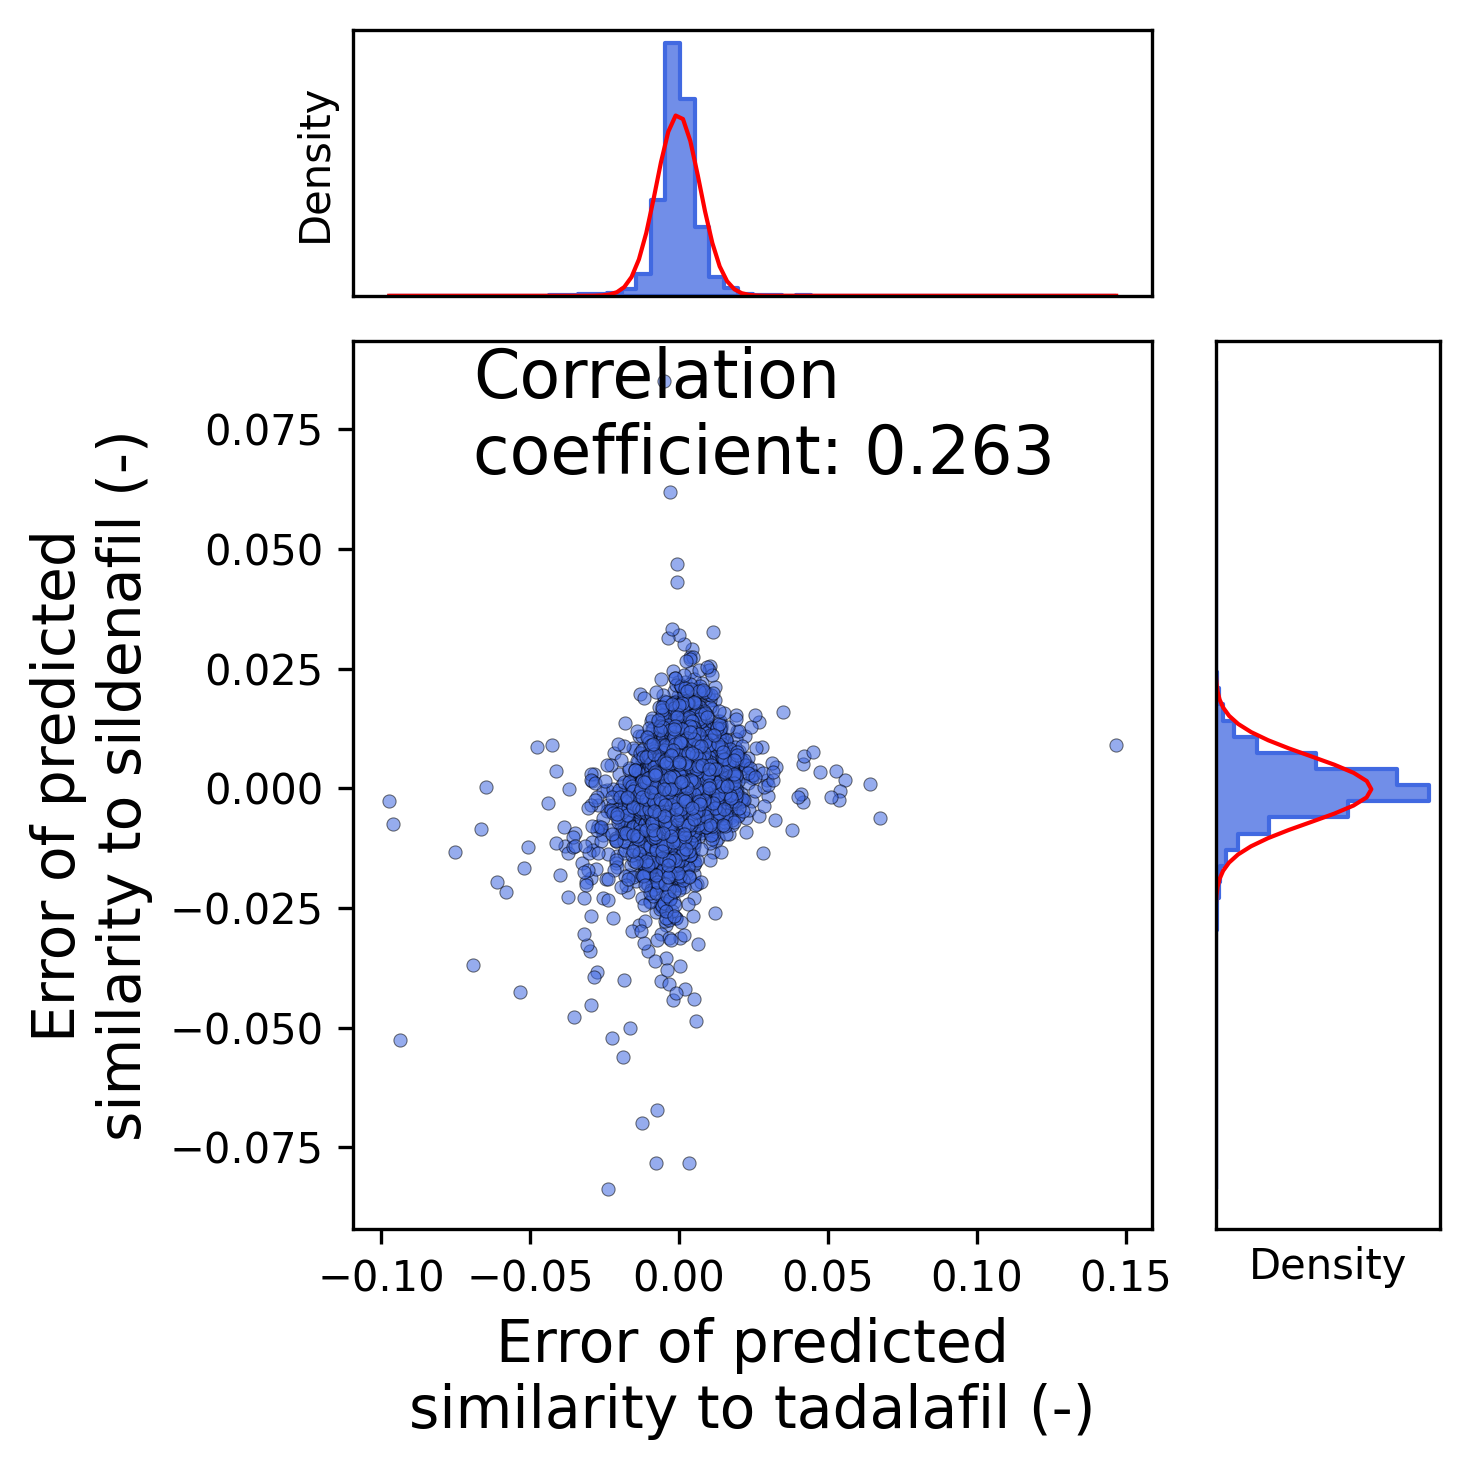

/tmp/ipykernel_52888/20081029.py:23: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax_scatter = plt.subplot2grid((4, 4), (1, 0), rowspan=3, colspan=3)


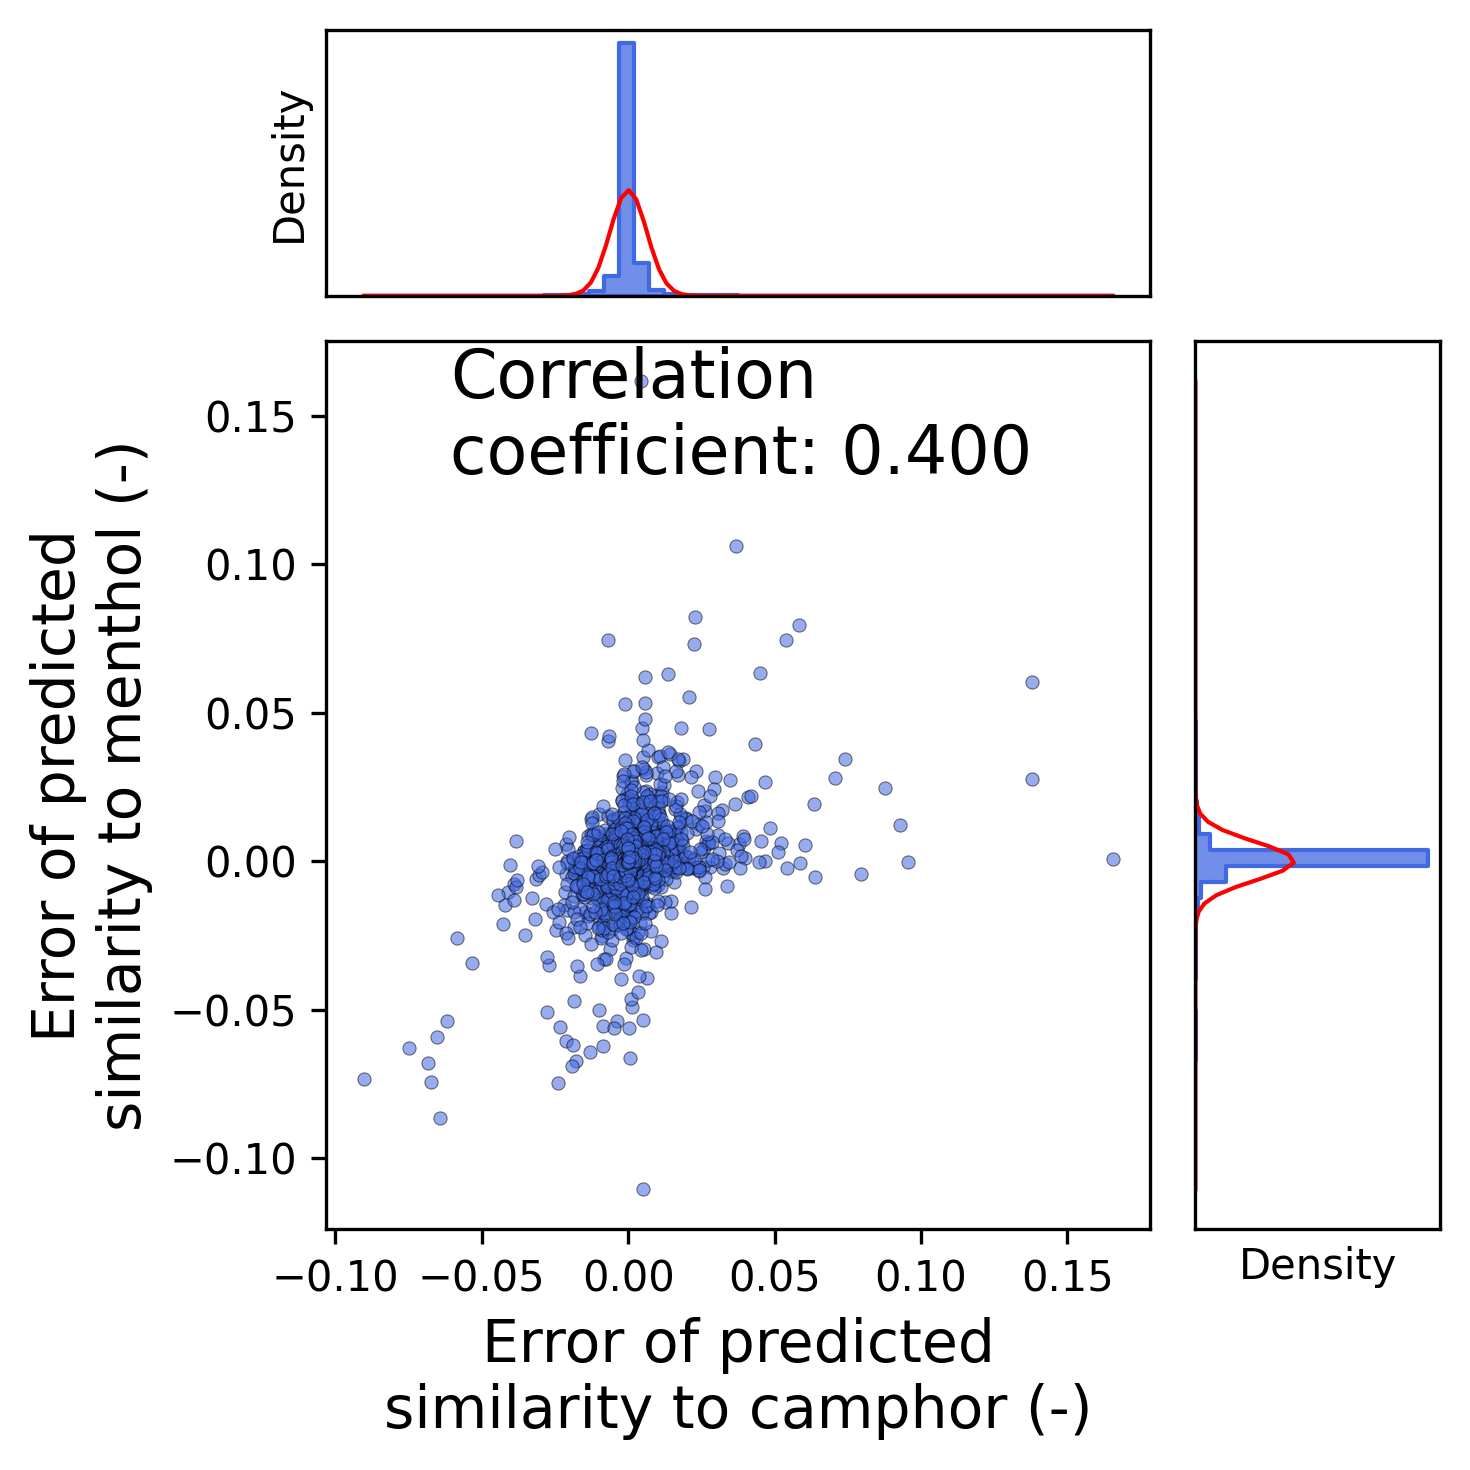

/tmp/ipykernel_52888/20081029.py:23: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax_scatter = plt.subplot2grid((4, 4), (1, 0), rowspan=3, colspan=3)


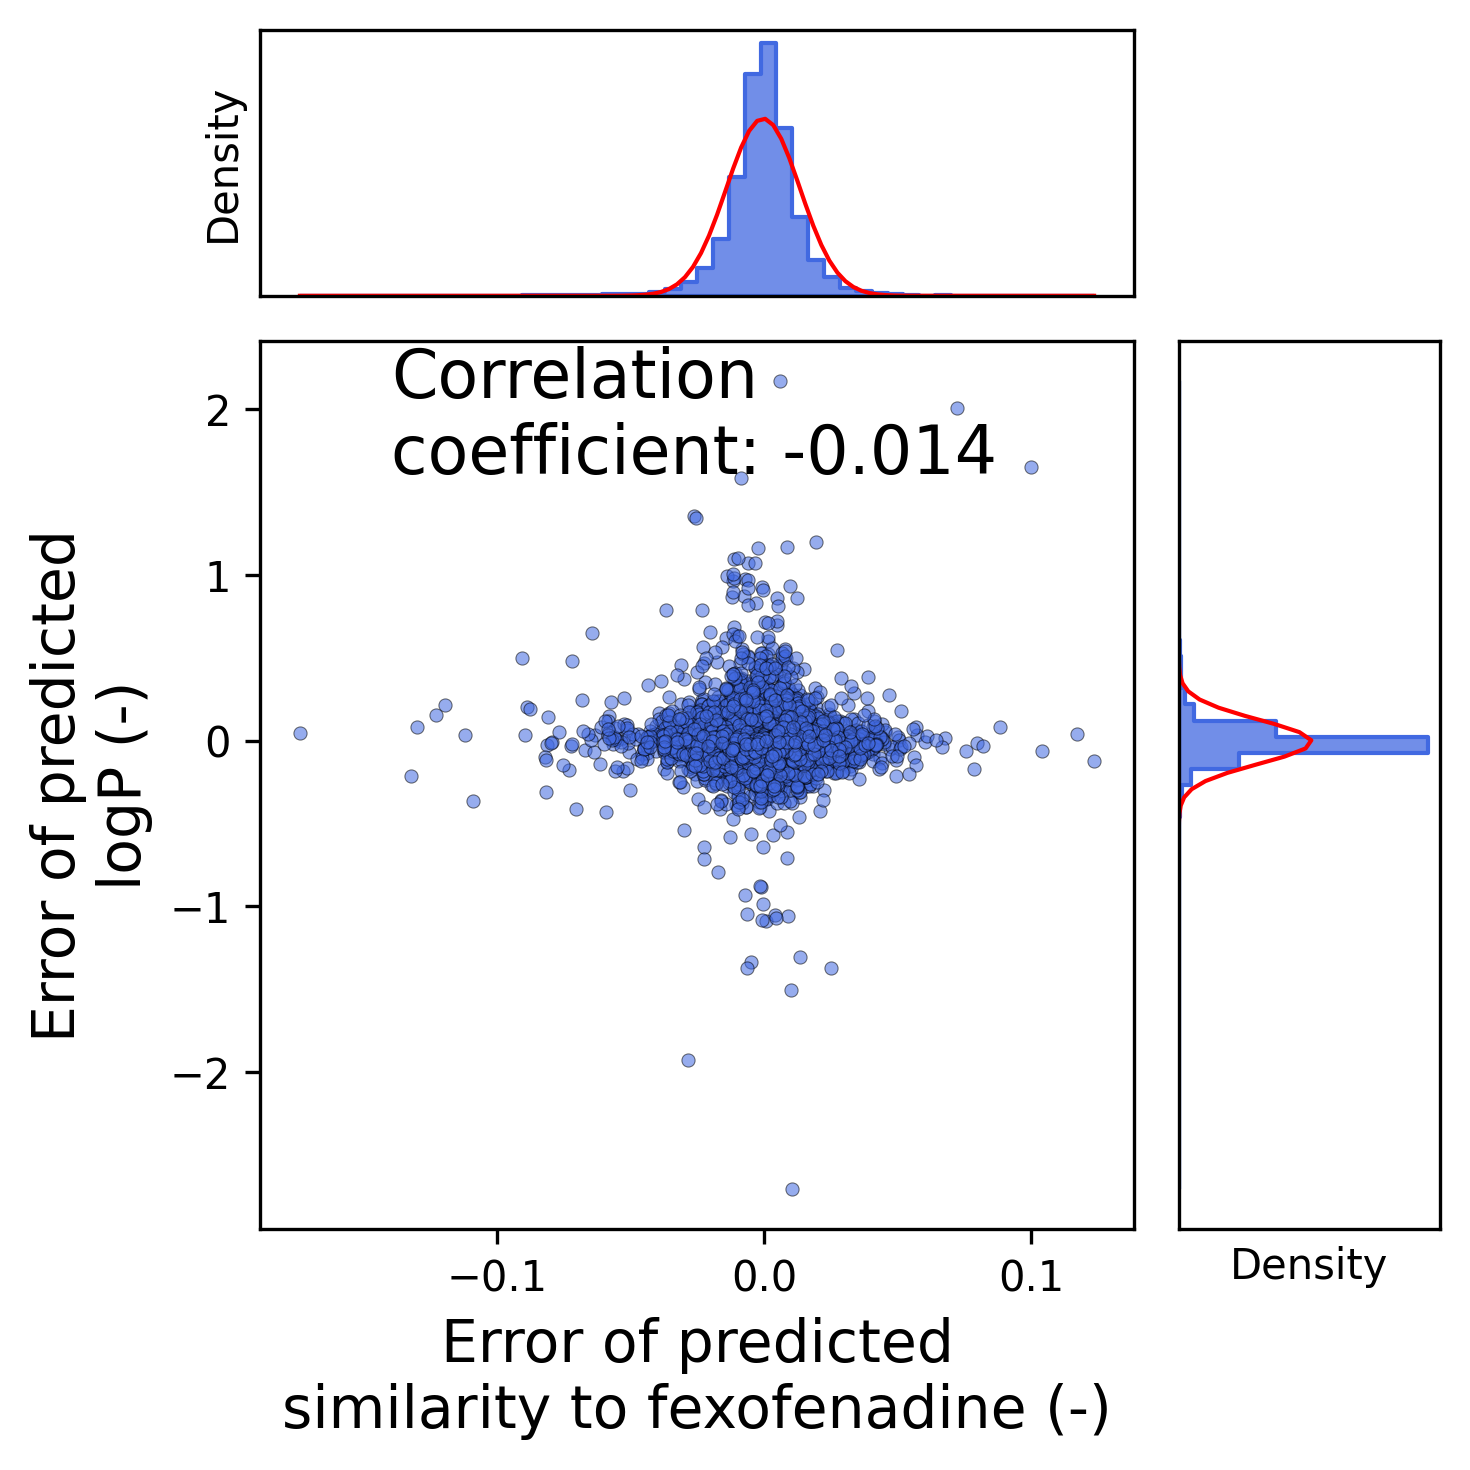

/tmp/ipykernel_52888/20081029.py:23: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax_scatter = plt.subplot2grid((4, 4), (1, 0), rowspan=3, colspan=3)


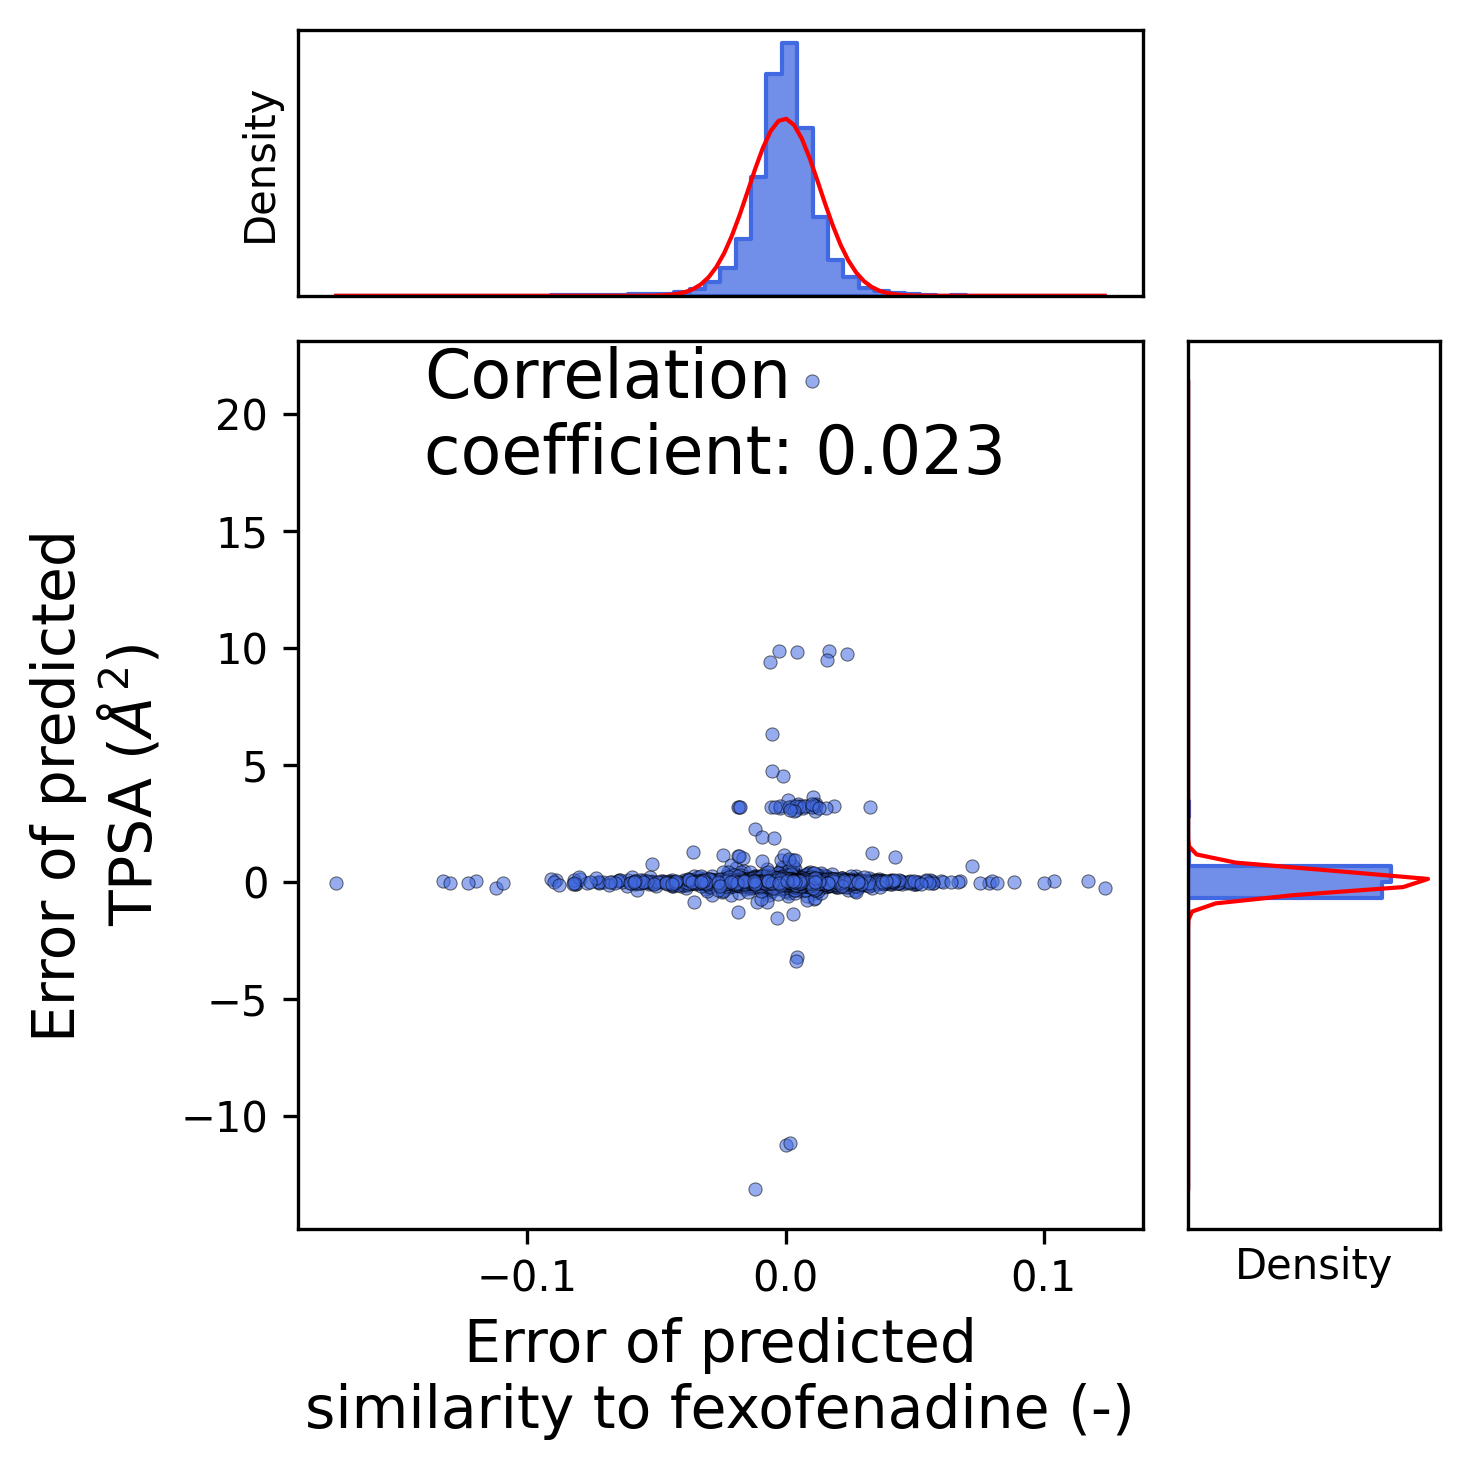

/tmp/ipykernel_52888/20081029.py:23: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax_scatter = plt.subplot2grid((4, 4), (1, 0), rowspan=3, colspan=3)


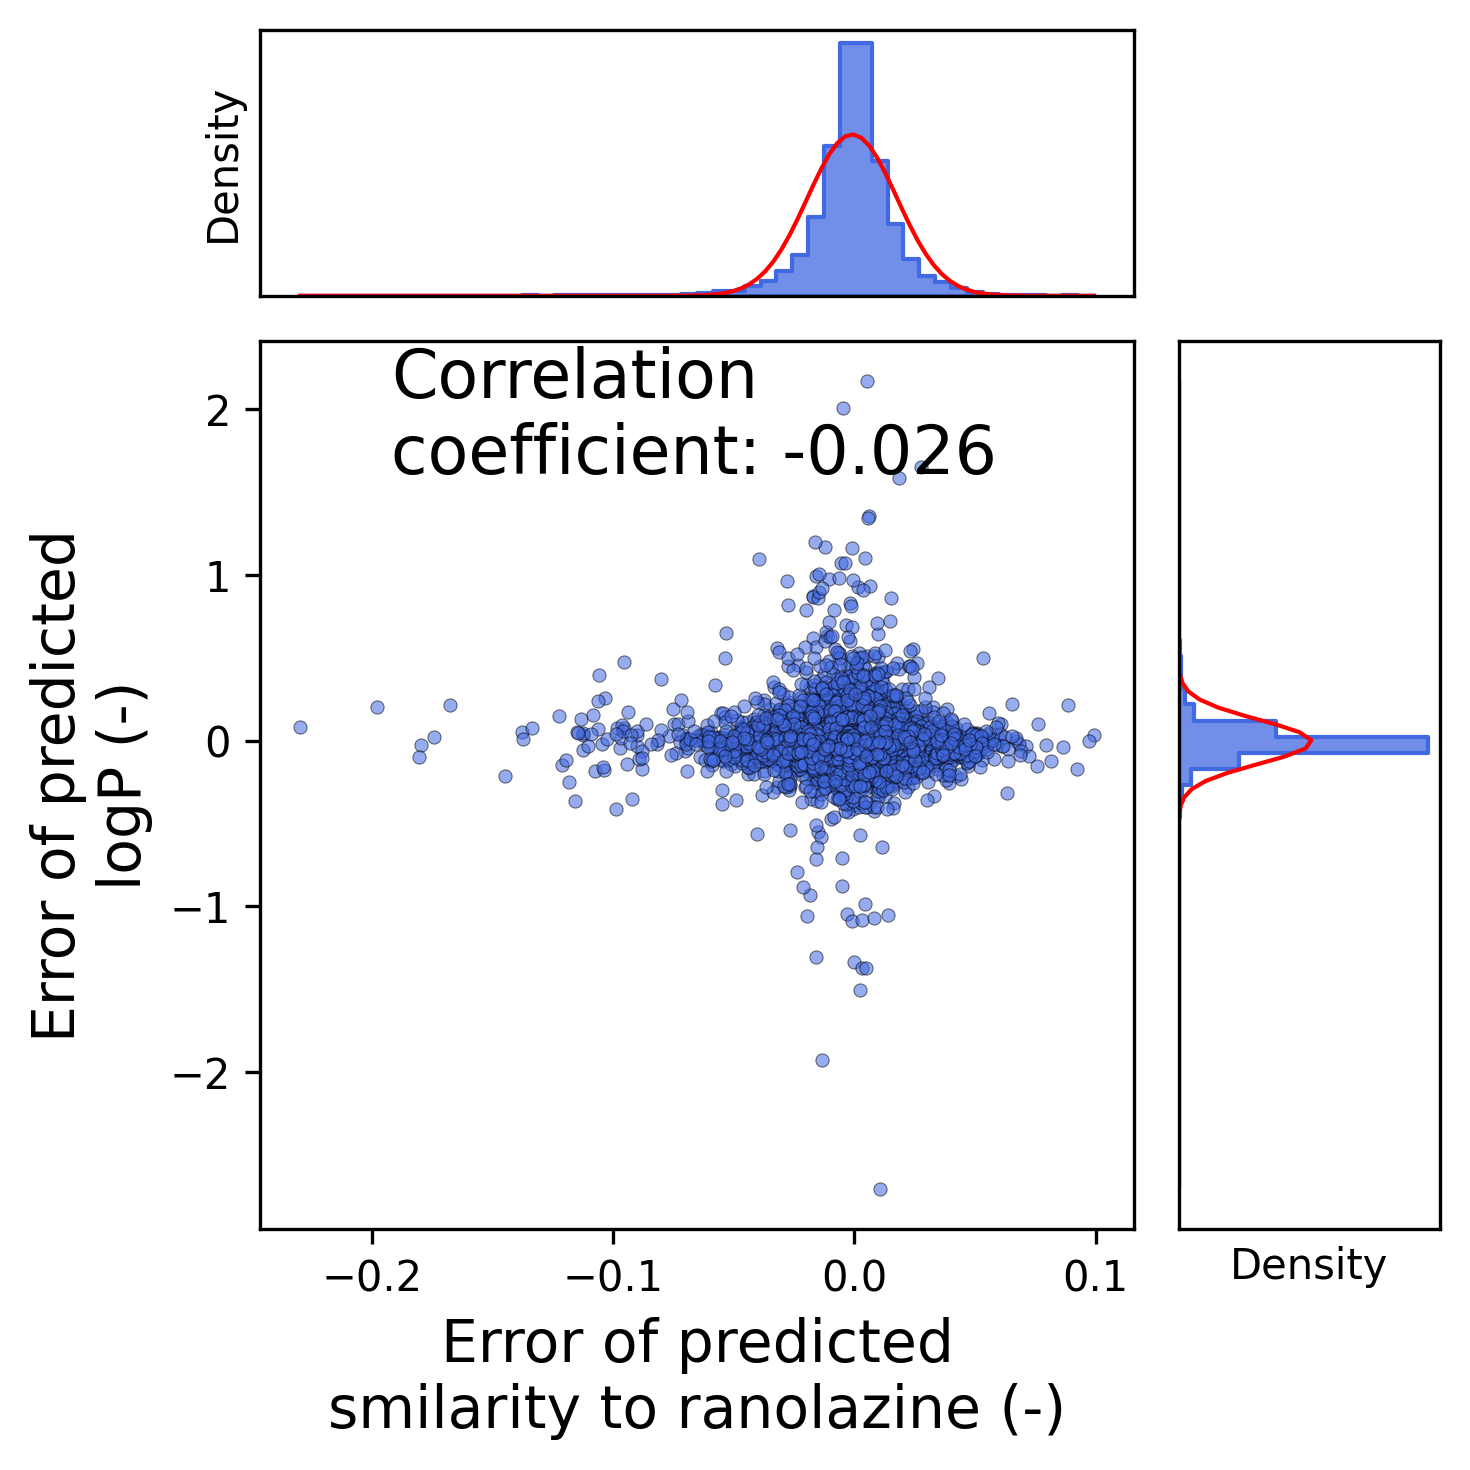

/tmp/ipykernel_52888/20081029.py:23: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax_scatter = plt.subplot2grid((4, 4), (1, 0), rowspan=3, colspan=3)


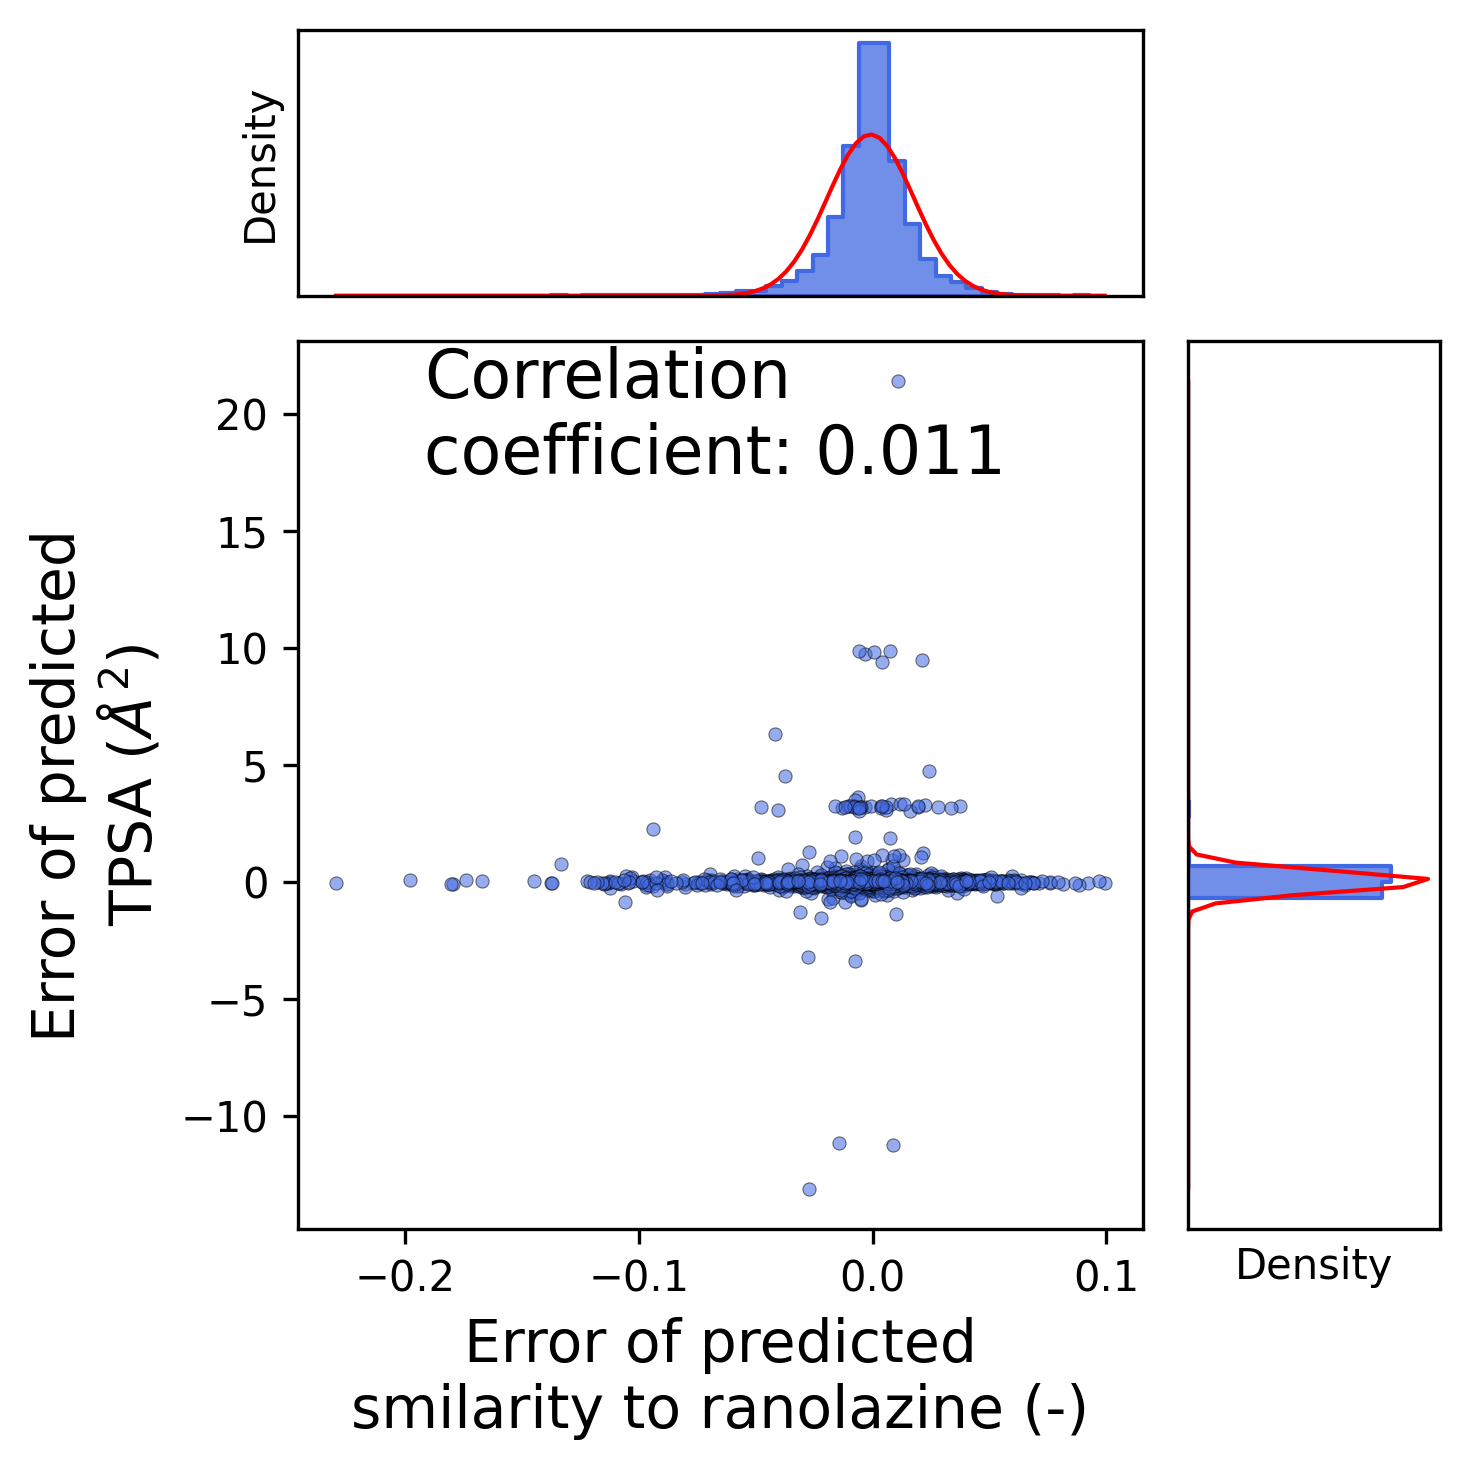

/tmp/ipykernel_52888/20081029.py:23: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax_scatter = plt.subplot2grid((4, 4), (1, 0), rowspan=3, colspan=3)


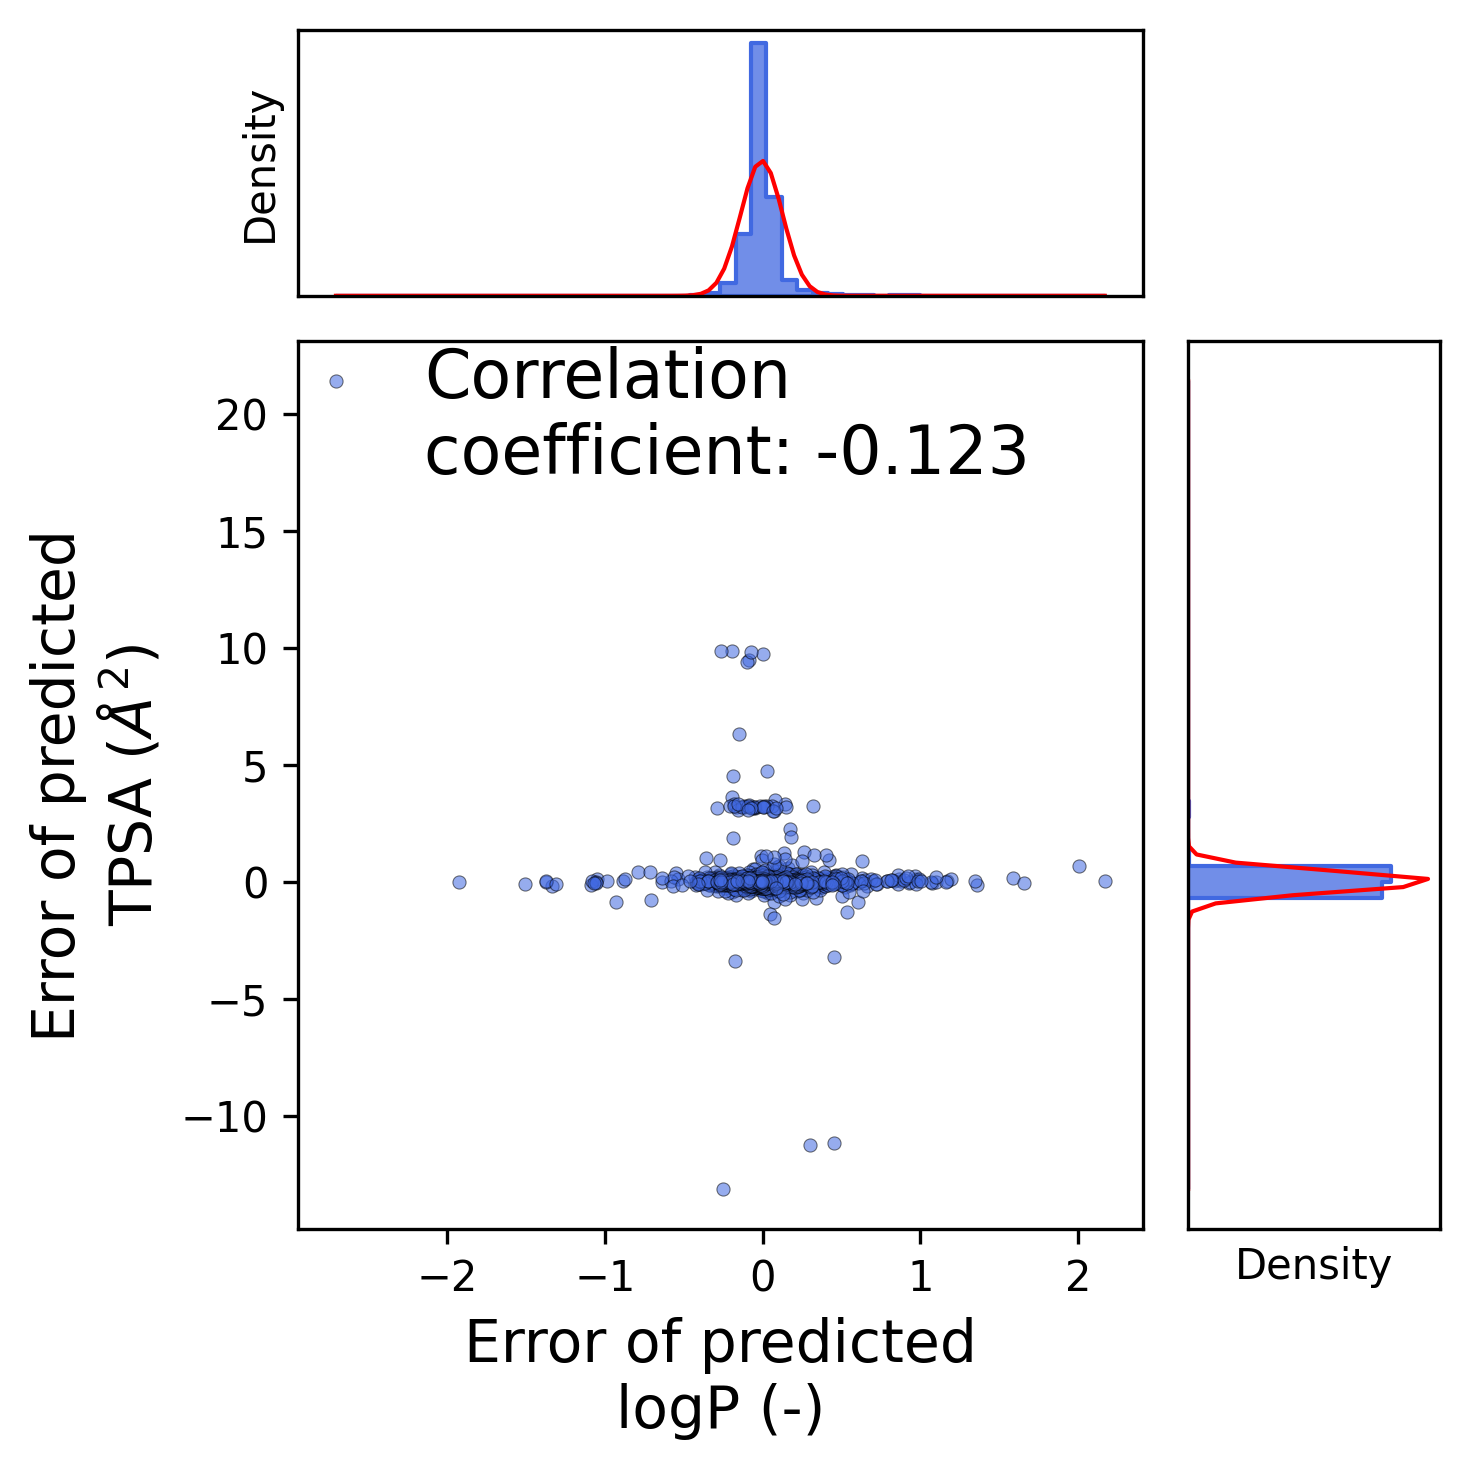

In [18]:
target_models = [[('similarity_Tadalafil', 'trial_30'), ('similarity_Sildenafil', 'trial_30')],
                 [('similarity_Camphor', 'trial_24'), ('similarity_Menthol', 'trial_20')],
                 [('similarity_Fexofenadine', 'trial_24'), ('logP', 'trial_3')],
                 [('similarity_Fexofenadine', 'trial_24'), ('tpsa', 'trial_24')],
                 [('similarity_Ranolazine', 'trial_19'), ('logP', 'trial_3')],
                 [('similarity_Ranolazine', 'trial_19'), ('tpsa', 'trial_24')],
                 [('logP', 'trial_3'), ('tpsa', 'trial_24')]]

for target_model in target_models:
    target_0, model_0 = target_model[0]
    target_1, model_1 = target_model[1]
    model_path = f"chemprop_unc/save_models/guacamol/{target_0}/{model_0}/fold_0"
    true_df = pd.read_csv("guacamol_benchmark/guacamol_dataset/guacamol_sample_test.csv")
    pred_df = pd.read_csv(os.path.join(model_path, "test_unc.csv"))
    true_0 = true_df[target_0]
    pred_0 = pred_df[target_0]
    model_path = f"chemprop_unc/save_models/guacamol/{target_1}/{model_1}/fold_0"
    pred_df = pd.read_csv(os.path.join(model_path, "test_unc.csv"))
    true_1 = true_df[target_1]
    pred_1 = pred_df[target_1]
    residual_0 = true_0 - pred_0
    residual_1 = true_1 - pred_1

    xlabel = "Error of predicted\n"+target_name_dict[target_0]
    ylabel = "Error of predicted\n"+target_name_dict[target_1]
    filename = target_0+"_"+target_1+".png"
    images_fies.append(f"./figures/finals/error_coorelation/{filename}")
    create_error_dist(residual_0, residual_1, xlabel=xlabel, ylabel=ylabel, save_path=f"./figures/finals/error_coorelation/{filename}")

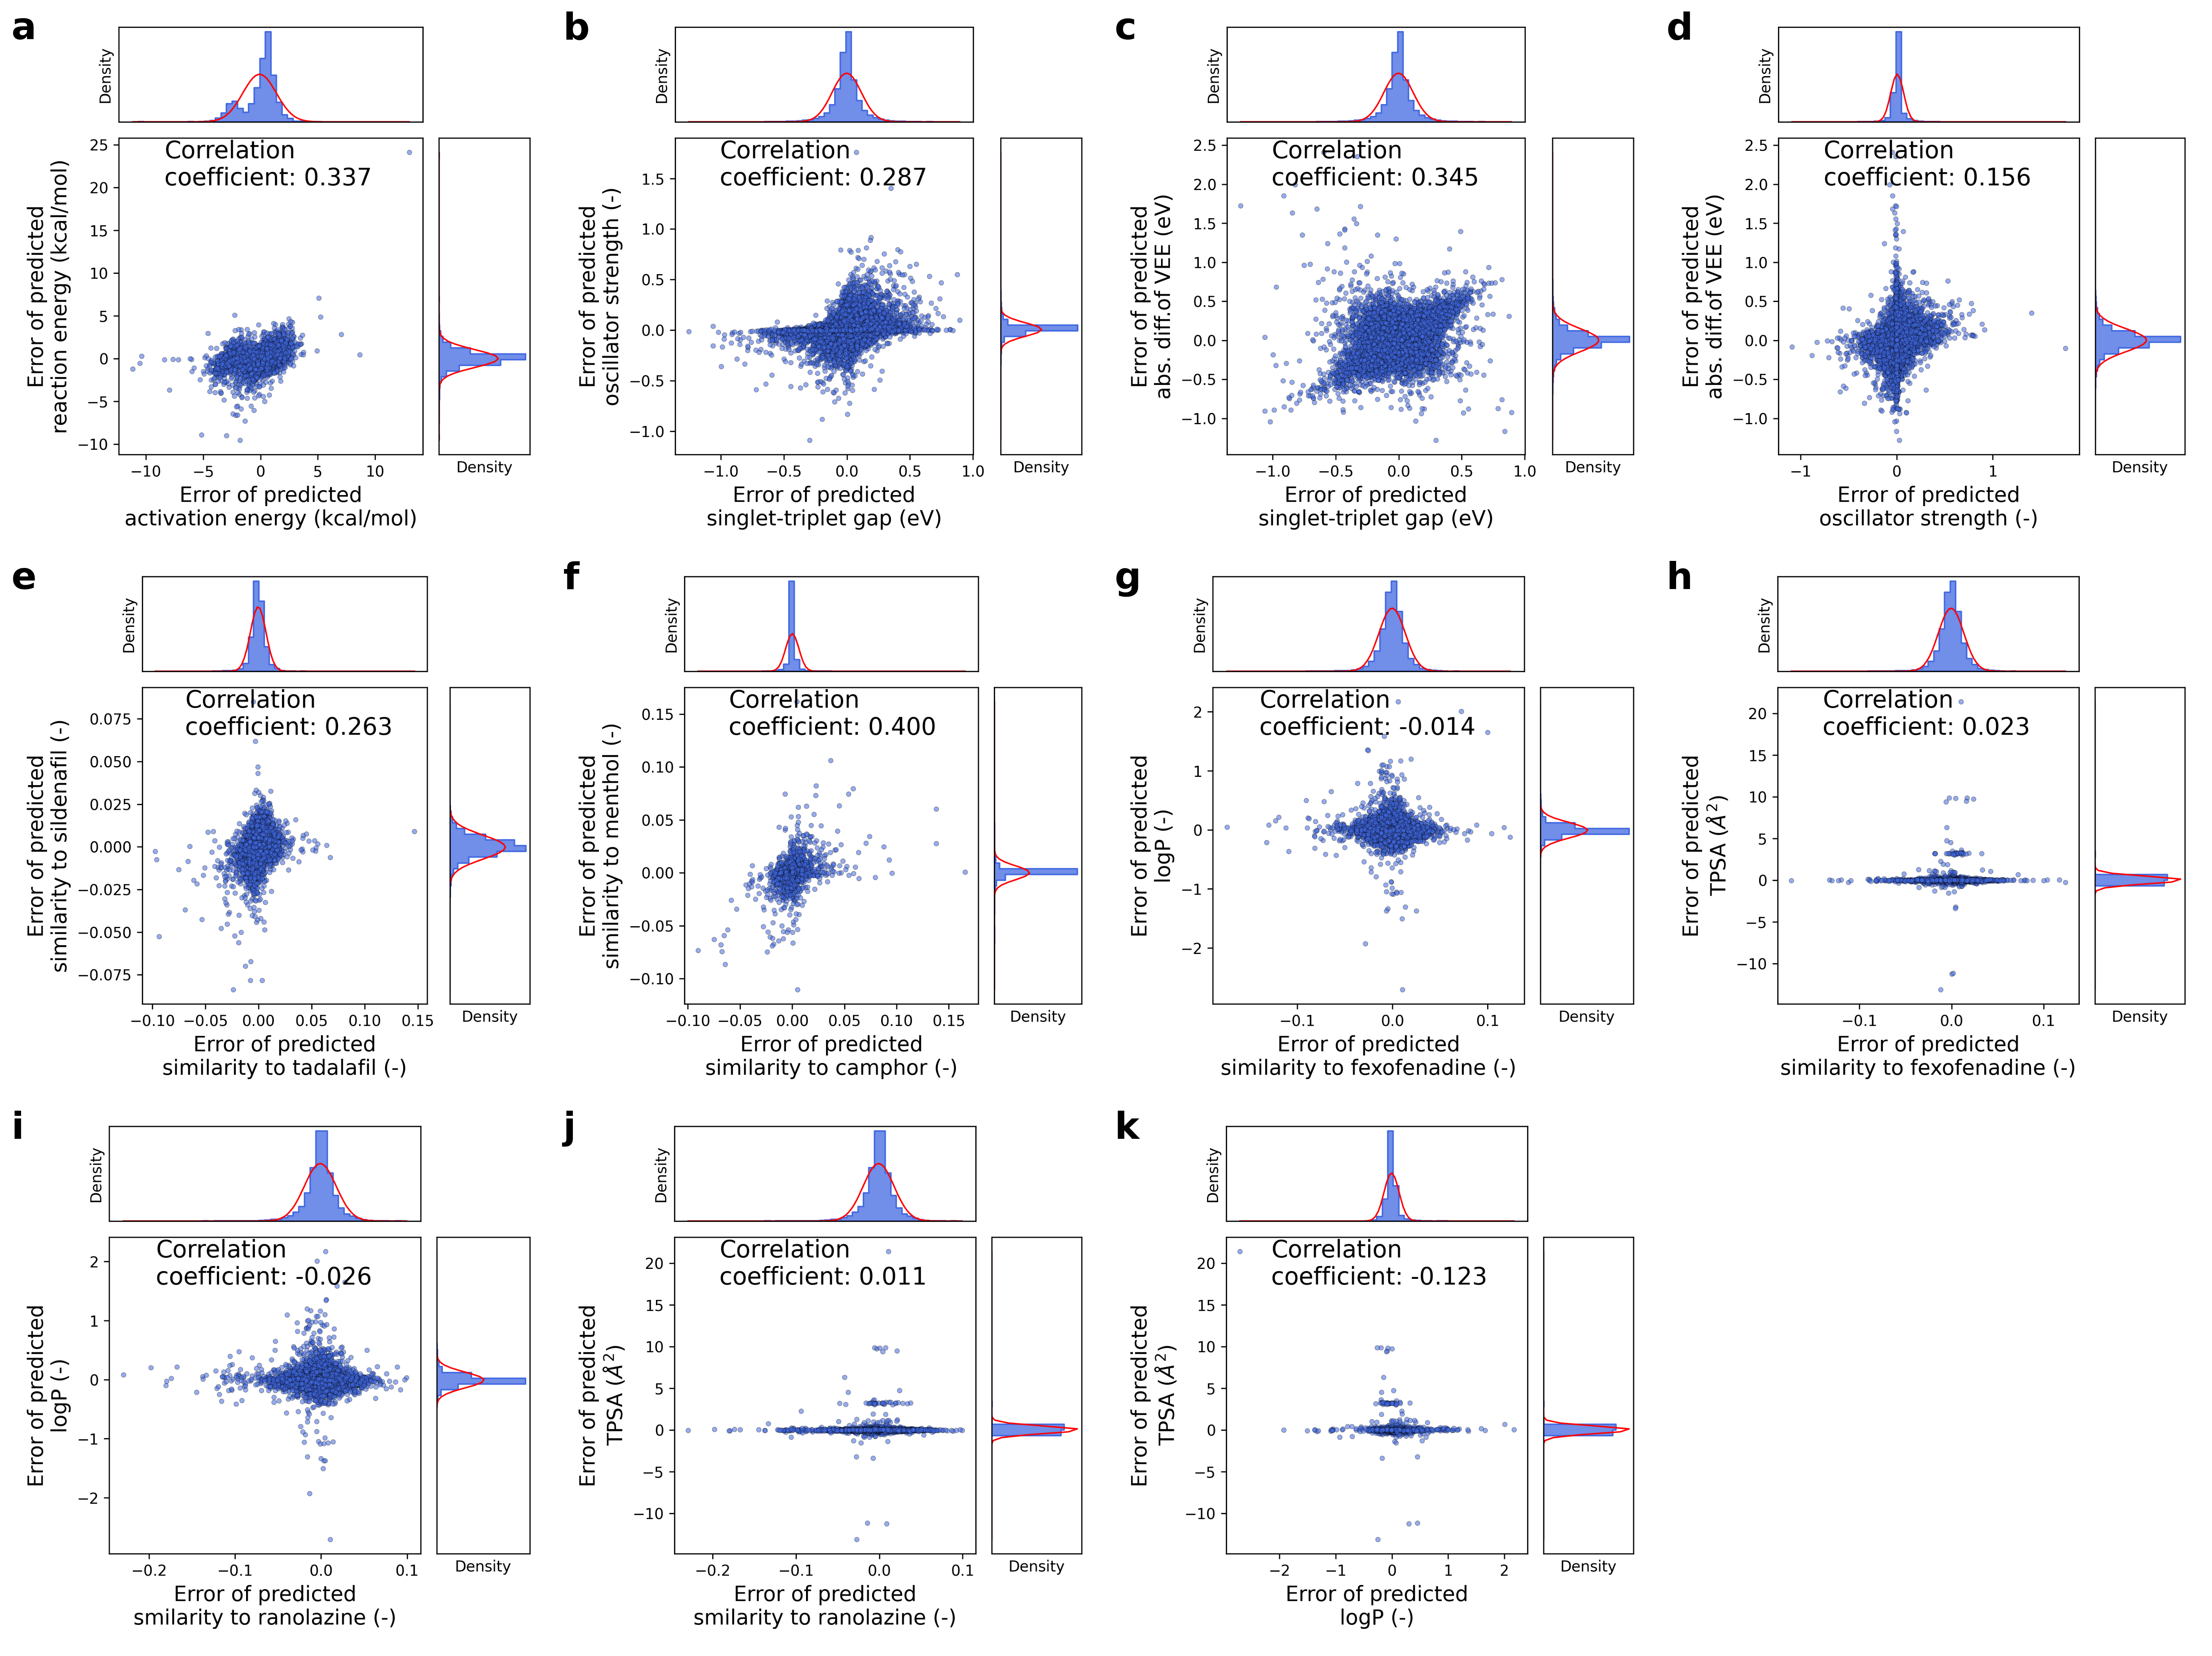

In [19]:
import matplotlib.pyplot as plt
from PIL import Image
import os


labels = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k',]

fig, axs = plt.subplots(3, 4, figsize=(20, 15), dpi=300) 

for i, ax in enumerate(axs.flat):
    if i == 11:
        ax.axis('off')
        break
    image_path = images_fies[i]
    if os.path.exists(image_path):
        img = Image.open(image_path)
    else:
        continue 

    ax.imshow(img)
    ax.axis('off')
    ax.text(-0.02, -0.06, labels[i], color='black', fontsize=24, va='top', ha='left', weight="bold")

plt.tight_layout()
plt.savefig('figures/finals/error_coorelation/combined.png')
plt.show()